In [1]:
# Importing some shizzle.

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import time
import requests
import datetime
import sys
import os
import pathlib
import seaborn as sns
from sklearn.metrics import roc_auc_score
import math
import json
import glob
import xlrd
import gzip
from utilities import perform_stats, calc_z_scores,\
    get_enrichr_results, plot_results,\
    plot_results_in_singleplot, plot_results_in_singleplot_iteractive_legend,\
    count_words_in_df, plot_count_results, split_and_count_words

# Defining some import and export locations
location = 'rjsietsma'
read_loc = '/home/'+location+'/Documents/School/Master_DSLS/Final_Thesis/Initial_Data_exploration/'
data_expor_loc = '/home/'+location+'/Documents/School/Master_DSLS/Final_Thesis/Past_initial_data/'
img_output_dir = '/home/'+location+'/PycharmProjects/dsls_master_thesis/side_scripts/output_img/'

In [2]:
# Some bokeh stuff

from bokeh.plotting import figure, ColumnDataSource, output_file, show, save
from bokeh.models import HoverTool, WheelZoomTool, PanTool,\
    BoxZoomTool, ResetTool, TapTool, SaveTool, FactorRange, Legend
from bokeh.palettes import inferno, Spectral5, viridis, Colorblind
from bokeh.transform import factor_cmap

Sprint 28-04-2020 - 19-05-2020 (?)
=====================

- What I want to do:
  1. [Focus on fixing missing CAPICE precomputed scores.](#Fixing-CAPICE-precomputed-scores) __Done__
      - _Note: Find out how the script of Shuang works on a smaller scale, get an example where a CAPICE score is missing._
  2. [Normalize BM_ratio](#Normalize-BM_ratio) for gene length, so $\frac{n_{malignant}}{n_{benign}}$ per 1000 bases in a gene, instead of [$\frac{n_{malign}}{n_{benign}} \times n_{total}$](output_img/bm_ratio.png "BM_ratio").
  3. _(questionable)_ Fix PCA by identifying categorical features _(Questionable because should I still put time and focus in on the input data?)_
      - _Ask Shuang, Joeri and Krista in the PRU 28-04-2020 @ 13:00-14:00_
  4. [See what is required](#Required-for-data-sources) for the [data sources](https://docs.google.com/document/d/1D5SiNbeDEfY2hTWquS88MGUrLv6IgZzfCzflppRGb5k/edit) to be implemented into the input data.
      - _Note: as this is research, I can use sources that only have precomputed scores available, but just to keep in mind that I should mention that in the discussion._

- Notes:
  - If I find myself unfocussed:
      - Win a game of [solitaire](https://play.google.com/store/apps/details?id=com.lemongame.klondike.solitaire&hl=nl) (game is rigged, not every match is win-able).
      - Clean out my closet (it's messy, maybe to clean up the mess inside my head too).
      - Go for a walk around the neighbourhood.

<br/><br/>
<br/><br/>
### Fixing CAPICE precomputed scores

Problem: CAPICE precomputed file of all single nucleotide level variants contains caps.

Solution: Fix the underlying problem that causes these gaps.

Required: 
- Script to make and batch the CAPICE computing __(positive check)__
- Access to GCC cluster __(positive check)__
- Knowledge of job scheduler on GCC cluster __(positive check)__
- Smaller batches of SNV files to run locally  __(positive check)__

Possible cause:
- Incorrect batching on tabix.

31-04-2020 Problem:
- Got it working on Gearshift, but with a problem:
    - AttributeError: Can't get attribute 'DeprecationDict' on <module 'sklearn.utils.deprecation' from '/apps/software/PythonPlus/3.7.4-foss-2018b-v20.02.1/lib/python3.7/site-packages/sklearn/utils/deprecation.py'>
- Which let's me to beleive that the model was trained in a previous version of sklearn.

<br/><br/>

- Update 10:51 : Model compatibility issue. Might have to retrain CAPICE on Gearshift using the latest xgboost, sklearn, scikit-learn, numpy and pandas just to be safe.

- Update 12:01 : Managed to get it working using python3.6 on calculon, essentially downgrading my own script (I only used python3.7 for F-strings)

- Update 15:55 : Found a very weird bug in the chunking. Seems like the script doesn't like to start at 0 with skiprows and 1000 nrows, solution: nrows - 2 when first iteration, then + 1, then start += nrows + 1...

- Update 04-05-2020 : Found out that the first iteration, an overhead of 2 variants was present. Adjusted the start with 2 to compensate. Seemed fine in the first 400000 CADD entries. (no duplicates nor missed entries). __Started full processing__

- Update 04-05-2020 : 
    - Add functionality to continue where left off if it crashes.
    - Make dummy script to check for duplicates or if the files are fully complete.
    
- Update 06-05-2020 : 
    - Functionaility to continue where left off is required. After 40 hours, it's still processing chromosome 1 after 7 million processed variants. 
        - Ideas: write json file with start and stop each iteration once that part is processed and added to the larger files. Should overwrite.
        - As for now, since this idea is not implemented yet, count the number of rows in the already processed files and set that as start.

- Update 11-05-2020:
    - The 4 days have ended, chromosome 1 has not been finished yet.
    - Output file of chromosome 1 has been renamed to a .tsv file and gzipped (saving about 5 gb of storage).
    - Adjustments to the original script have to be made.
   

#### Version 2.0

- Added gzip output by default
- Currently no function yet to continue where left off.
    - Ideas:
        - for line in gzip.open(file.gz): nlines+=1 (to trace back where was left off)
            - Do not know if this lead to any complications of duplicated entries. Saving the previous results in the RAM memory might solve this to compare to.
    - Then in the future:
        - Save a json of start and batch size each iteration to mark where the file was left of.

- Update 15-05-2020:
    - Program did not load in the previous results correctly, resulting in 12 duplicates (111400001-111400012) (including start and stop). Discuss with Joeri and Shuang what to do. It takes roughly 200 MB of ram to load in 2.1 million processed variants, calculating this for 111.4 million variants (that's how much there is in the file now), would come down to ~11GB of ram usage.

- Update 18-05-2020:
    - Script to remove duplicates from the CAPICE processed file has been run and duplicates have been removed.
    - First test runs have been ran, only for me to realised I messed up. I kept copying the main class, instead of the calculate_capice class. Final release should be on this date.
    

<br/><br/>
<br/><br/>
### Normalize BM_ratio

Problem: Larger genes have more benign and malignant samples, because they are larger and thus the chanses of variation on the reference read is higher.

Solution: Make a $n_{malignant}$ and $n_{benign}$ per $x$ bases in a gene, where {$x \in \mathbb{N}\ | x \geq 1 | x \leq 10000$}

<br/><br/>
<br/><br/>
### Required for data sources

Problem: Now that a lot of data sources have been found, annotation and merging has to be performed in order to use it as training data.
- _Additional problem: once a source has been proven beneficial, it has te be implemented to be annotated before capice fits and predicts a new sample._

Solution: Find out, feature by feature if genes that have a low AUC improve *__and that genes that have a high AUC do not perform worse__*

Required:
- Storage 
    - On GCC cluster for precomputed score files.
    - Locally IF file isn't that big or an API can be used.
- Data sources __([positive check](https://docs.google.com/document/d/1D5SiNbeDEfY2hTWquS88MGUrLv6IgZzfCzflppRGb5k/edit))__
- Script to annotate / merge


      

# CTEPG (Catching The Elusive Predictable Genes) 28-04-2020 - 04-05-2020
<br/><br/>

What have I done:

- [Enrichr Genes < 0.6](https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=b7a959357214069d1905719220ed3e3b)
- [Enrichr Genes < 0.7](https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=7d252a3e1df275859228fd562e964344)
    - For reference: [Enrichr Genes < 0.85](https://amp.pharm.mssm.edu/Enrichr/enrich?dataset=60c74741c967c25331419bd2b5e7183e)
- [Finished investigating initial data sources](https://docs.google.com/document/d/1D5SiNbeDEfY2hTWquS88MGUrLv6IgZzfCzflppRGb5k/edit)

<br/><br/>
<br/><br/>

What I'm planning to do this week:

- [Fixing missing values in precomputed CAPICE scoring file](#Fixing-CAPICE-precomputed-scores). __Done and not done, script has to have some additonal features__
    - If stuck, do not keep walking into the wall, continue below and contact Shuang and Joeri
- [Run enrichr on increasing cutoffs in AUC (.5, .6, .7 etc.)](#Enrichr-automated-API). __Done__
    - Read into the [Enrichr API documentation](https://amp.pharm.mssm.edu/Enrichr/help#api)
- Mail Tsjerk that a meeting is apreciated. __Done, no response yet__
- Make [suggested plot](https://docs.google.com/presentation/d/1_woKoD9nqWnxueyFYfwyX6B4owg8vYF7rw_nKpMPux4/edit#slide=id.p). __Done__
    - Select from enrichr all the genes involved in (lipid) metabolism and see if this explains all / most of the bad performing genes.
- Make model on bad performing genes and investigate further.
- Start investigating what is required for the data sources to be used in the training phase.
- Look into the genes that do perform well without a CGD category, also look into the 1/2 genes that do not perform well __with__ a CGD category
- _Optionally_ :
    - Create outline for article.
    - Adjust BM_ratio plot to normalize for gene length.
    - Get the UMCG gene panel lists into python
        - Then: investigate which gene panel is performing the worst.
        - It would be nice to have this on the side for diagnostics, do __not__ focus on this
    - Fix PCA.
    - Find possible way to annotate genes for co-factors, sub-family etc.
<br/><br/>

# CTEPG (Catching The Elusive Predictable Genes) 04-05-2020 - 11-05-2020
<br/><br/>

What have I done:
- [Fixing missing values in precomputed CAPICE scoring file](#Fixing-CAPICE-precomputed-scores).
- [Run enrichr on increasing cutoffs in AUC (.5, .6, .7 etc.)](#Enrichr-automated-API).
- Make [suggested plot](https://docs.google.com/presentation/d/1_woKoD9nqWnxueyFYfwyX6B4owg8vYF7rw_nKpMPux4/edit#slide=id.p).
<br/><br/>

Planned for this week:
- Release precomputed CAPICE script v2.0
- Investigate Bokeh plots on commonalities between Adjusted P-value of 0-0.2 and AUC of 0.5-~0.75 and try to find features / links that would be beneficial to train a separate model on. (or prehaps just train a new model without features and see if performance improves)
    - Ion transport / transmembrane related genes seems to perform bad. 
    - Find commonalities between y-axis 0-0.2 and x-axis 0-0.7
    - Make model on bad performing genes and investigate further.
        - Make plots combined of all sources, but color them by source.
- Start investigating what is required for the data sources to be used in the training phase.
- Look into the genes that do perform well without a CGD category, also look into the 1/2 genes that do not perform well __with__ a CGD category
- _Optionally_ :
    - Create outline for article.
        - For static plots: make labels on each point with the term name and the number of genes in (n=x) behind that.
    - Adjust BM_ratio plot to normalize for gene length.
    - Get the UMCG gene panel lists into python (calculate average AUC for each panel, take the worst performing onces and retain).
        - Then: investigate which gene panel is performing the worst.
        - It would be nice to have this on the side for diagnostics, do __not__ focus on this
    - Find possible way to annotate genes for co-factors, sub-family etc.
    - Interactive plot of all variants labeled as benign or pathogenic with their capice score (y-axis) and location (x-axis), to show the variant itself.
<br/><br/>

# CTEPG (Catching The Elusive Predictable Genes) 11-05-2020 - 18-05-2020
<br/><br/>

What have I done:
- [Fixing missing values in precomputed CAPICE scoring file](#Fixing-CAPICE-precomputed-scores).
- Make more bokeh plots on enrichr results
    - ~[Investigate correlations between AUC's and Adjusted P-value](#Correlation-analysis-Enrichr-results).  (spearman / pearson, preverably spearman). Keep in mind that the distribution is not linear, but more like a normal distribution like.~
        - ~Make legend interactive to confirm normal distribution like.~
    - Chromosome X seems enriched for higher AUC thresholds. Bias in the source data? (Put in discussion). Lot's of developmental delay reseach is linked / correlated to chromosome X.

Planned for this week:
- ~Release precomputed CAPICE script v2.0.~
- ~Run correlation test for all possible sources on Enrichr to maximize chanses of finding stuff.~
    - ~Look into a good way to get all possible results from the enrichr API.~ __Not possible.__
- ~Escalate mail contact with Tsjerk to Martijn and Fenna.~
    - __Unneeded, Tsjerk replied.__
- ~Investigate Bokeh plots on commonalities between Adjusted P-value of 0-0.2 and AUC of 0.5-0.75 and try to find features / links that would be beneficial to train a separate model on.~ (or prehaps just train a new model without features and see if performance improves)
    - Ion transport / transmembrane related genes seems to perform bad. 
    - ~Find commonalities between y-axis 0-0.2 and x-axis 0-0.7~
    - __Make model on bad performing genes and investigate further.__
        - ~Make plots combined of all sources, but color them by source.~
- Use regex `x[~x['INFO'].str.contains('CLNSIG=Uncertain_significance')]` to find all variants within the clinvar database that are not VUS'es
- Start investigating what is required for the data sources to be used in the training phase.
- Look into the genes that do perform well without a CGD category, also look into the 1/2 genes that do not perform well __with__ a CGD category
- _Optionally_ :
    - __Create outline for article.__
        - For static plots: make labels on each point with the term name and the number of genes in (n=x) behind that.
        - For first concept, it's due date is the last week of the resit exams on the 6th of July.
    - Adjust BM_ratio plot to normalize for gene length.
    - Get the UMCG gene panel lists into python (calculate average AUC for each panel, take the worst performing onces and retain).
        - Then: investigate which gene panel is performing the worst.
        - It would be nice to have this on the side for diagnostics, do __not__ focus on this
    - Find possible way to annotate genes for co-factors, sub-family etc.
    - Interactive plot of all variants labeled as benign or pathogenic with their capice score (y-axis) and location (x-axis), to show the variant itself.
<br/><br/>
    
## For after I graduate:
<br/><br/>
Make a script that for every gene, for every gene makes a plot like [these](https://molgenis26.gcc.rug.nl/downloads/capice/plots/), but then interactive that if you hover over a point you see it's chromosomal location, ref and alt and maybe an RS number?

- If input of CAPICE is not CADD annotated, annotate in capice locally and only return the capice scores.
 <br/><br/>
 
 # CTEPG (Catching The Elusive Predictable Genes) 02-06-2020 - 15-06-2020
<br/><br/>

What have I done:
- Get the UMCG gene panel lists into python (calculate average AUC for each panel, take the worst performing onces and retain).
     - Then: investigate which gene panel is performing the worst.
        - It would be nice to have this on the side for diagnostics, do __not__ focus on this
- Finished investigating Enrichr pathways. Only a couple are upregulated significantly when the AUC gets higher.

Planned for this week:
- ~Finish investigating Enrichr results.~
    - ~Make [suggested plots](https://docs.google.com/presentation/d/1e4zBxhPAGORXYJG0bulR1ADb68haa58v-agkFcv_cxQ/edit#slide=id.p).~
        - ~Plot 1: Color by main category and plot each panel average AUC in 1 bar plot to see if main categories cluster low / high.~
        - ~Plot 2: Compare all genes in 1 main category to all other categories independently P-values using the wilcoxon test. Play around with the test to see if higher / lower / other is applicable.~
- Make model on bad performing genes and investigate further.
- ~__Think about the following:__~
    - ~Work through the summer holiday as extra time to do research, potentially ending up with something amazing.~
    - ~Rush to get article / report finished, have summer holidays 'off' to do other school related stuff and relax a bit, potentially missing something amazing.~
- ~Make plot of Hart- en vaatziekten vs all other panels combined (minus 5GPM)~
- ~Make plot of Hart- en vaatziekten vs 5GPM~
- ~How many variants do I have in Hart- en vaatziekten, dyslipidimie (total)?~
    - If not enough variants are found (benign, malignant or total), look into [this](https://databases.lovd.nl/shared/variants/).
        - Usefull, [convert to vcf](http://grch37.ensembl.org/Homo_sapiens/Tools/VEP).
- Usefull, [convert 37 to 38](https://genome.ucsc.edu/cgi-bin/hgLiftOver).
- Start investigating what is required for the data sources to be used in the training phase.
- Look into the genes that do perform well without a CGD category, also look into the 1/2 genes that do not perform well __with__ a CGD category.
- Create outline for article.
     - For static plots: make labels on each point with the term name and the number of genes in (n=x) behind that.
     - For first concept, it's due date is the last week of the resit exams on the 6th of July.
- _Optionally_ :
    - Adjust BM_ratio plot to normalize for gene length.
    - Find possible way to annotate genes for co-factors, sub-family etc.
    - Interactive plot of all variants labeled as benign or pathogenic with their capice score (y-axis) and location (x-axis), to show the variant itself.
<br/><br/>
 
 # CTEPG (Catching The Elusive Predictable Genes) 15-06-2020 - 22-06-2020
<br/><br/>

What have I done:


Planned for this week:
- Make model on bad performing genes and investigate further.
    - At first, make models of [the original training data](https://zenodo.org/record/3564757#.XudiZ2ixUUE), models of various gene panels (but keep the variants of those panels within the bigger model). See if they improve and how much.
    - Then make a single model of the original training data for CADD 1.6 annotations.
    - Then make multiple models of the original training data for CADD 1.6 annotations.
    - Investigate improvements.
    - Then choose between:
        - newer / larger dataset or 
        - Custom features that might be relevant to the cause (prefered)
- Make single plot of panel vs all others combined (except for 5GPM).
- Usefull, [convert 37 to 38](https://genome.ucsc.edu/cgi-bin/hgLiftOver).
- Start investigating what is required for the data sources to be used in the training phase.
- Create outline for article.
     - For static plots: make labels on each point with the term name and the number of genes in (n=x) behind that.
     - For first concept, it's due date is the last week of the resit exams on the 6th of July.
- _Optionally_ :
    - Find possible way to annotate genes for co-factors, sub-family etc.
    - Interactive plot of all variants labeled as benign or pathogenic with their capice score (y-axis) and location (x-axis), to show the variant itself.
<br/><br/>



  
    

# Current Tickets:
<br/><br/>

## As student / Robert I want to map requirements for SNV and gene features.

- Content:

Overview of features has now been collected and processed (https://docs.google.com/document/d/1D5SiNbeDEfY2hTWquS88MGUrLv6IgZzfCzflppRGb5k/edit). In order to use these features, knowledge has to be obtained for the requirements on said features including, but not limited to merging to the trianing dataset and storage.

- Acceptance criterea:
    - Does not take up terrabytes of storage.
        - _If it does, data sources might have to be merged 1 by 1, removing the source after the merge._
    - Can be merged without 3rd party software (tabix, python etc. allowed).
    - Data can easily be downloaded.

<br/><br/>

## ~As student / Robert I want to find commonalities between bad performing genes in CAPICE~

- Content:

The enrichr tool has proven to be quite beneficial to understanding a set of bad performing genes. Further processing of these enrichr results is required in order to fully understand the underlying mechanics and commonalities that these bad performing genes share.

- Acceptance criterea:
    - Enrichr is performed on multiple gene sets of different AUC thresholds (0.5, 0.6, 0.7 etc.).
    - Results of various data sources (kegg, bioplanet, wikipathways etc.) have been obtained in an automated way using the Enrichr API.
    - Results from the Enrichr API have been processed in an understandable plot, an mockup can be found [here](https://docs.google.com/presentation/d/1_woKoD9nqWnxueyFYfwyX6B4owg8vYF7rw_nKpMPux4/edit#slide=id.p).

<br/><br/>

## As CAPICE user I want to use the best possible performing model

- Prerequisites:

    - As Bioinformatician I want to update CAPICE by preprocessing train test datasets to include all features that CAPICE learns on.
    - As researcher I want to know in detail how sample weights are applied.
    

- Content:

Even though CAPICE performs really well, there is room for improvement. Subsetting genepanels in the model training and predicting phase might prove beneficial to the performance of CAPICE. Furthermore, the model must be updated a bit to fit certain quality of life improvements (see acceptance criterea).

- Acceptance criterea:
    - Performance of all gene panels must not worsen.
    - Subsetting the variants of the different panels must happen within the model.
    - The model must be able to run on python 3.6 and python 3.8 for future proofing.
    - Performance must increase with as least additional features as possible.
        - For this, sample size must remain within acceptable boundaries. (acceptable is discussable)
        - Additional features shall focus primarily on gene level to limit storage and processing stress.
        - When variant level features shall be added, this shall be performed one datasource at a time, again to limit stress.
        - Additional features must be beneficial for all gene panels.
            - Certain features might prove beneficial to a certain gene panel, but not to others, could indicate that the cause of worse performance for that certain panel lies within that feature.
    - The model will be created for genome build 37 in the first place, but in such a way that build 38 can easily be added as supported.
    - The model must support CADD 1.4 and CADD 1.6
        - CADD 1.5 is basically CADD 1.4 but with fixed GERP annotations for build 38.
    - The model must use precomputed scores first. When no precomputed score is found for the variant, it shall be computed.
    

# Enrichr automated API

In [3]:
enrichr_url = 'http://amp.pharm.mssm.edu/Enrichr/'

In [4]:
# Load in initial data
data = pd.read_csv(read_loc+'optimal_f1_full_ds_v2.csv', header=0)
data.sort_values(by='default_f1', ascending=False)

,gene,default_auc,default_f1,default_recall,default_fpr,default_spec,optimal_c,optimal_auc,optimal_f1,optimal_recall,optimal_fpr,optimal_spec,n_tot,n_benign,n_malign
2775,PRKN,1.000000,1.0,1.0,0.0,1.0,0.020,1.000000,1.000000,1.0,0.0,1.0,11,7,4
1659,BUB1B,1.000000,1.0,1.0,0.0,1.0,0.020,1.000000,1.000000,1.0,0.0,1.0,73,66,7
2102,GALNT3,1.000000,1.0,1.0,0.0,1.0,0.020,1.000000,1.000000,1.0,0.0,1.0,12,10,2
1655,PNPLA1,1.000000,1.0,1.0,0.0,1.0,0.020,1.000000,1.000000,0.8,0.2,0.8,31,26,5
2782,TMEM80,1.000000,1.0,1.0,0.0,1.0,0.020,1.000000,1.000000,1.0,0.0,1.0,5,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2625,C10orf2,0.469697,0.0,0.0,1.0,0.0,0.020,0.469697,0.000000,0.0,1.0,0.0,133,132,1
2330,SPTLC2,0.455157,0.0,0.0,1.0,0.0,0.011,0.750374,0.170213,0.0,1.0,0.0,229,223,6
2615,PLCD1,0.500000,0.0,0.0,1.0,0.0,0.020,0.500000,0.000000,0.0,1.0,0.0,8,7,1
2611,UBE2A,0.500000,0.0,0.0,1.0,0.0,0.020,0.500000,0.000000,0.0,1.0,0.0,3,2,1


In [5]:
data.shape[0]

2807

In [6]:
data[['n_tot', 'n_benign', 'n_malign']].sum()

n_tot       303911
n_benign    240104
n_malign     63807
dtype: int64

In [7]:
# Make a dictionary of lists of genes of interest with as key the 0.x threshold

auc_dict = {}
thresholds = np.arange(0.5, 1.01, 0.05).round(decimals=2)
for t in thresholds:
    list_of_genes = data[data['default_auc'] < t]['gene'].tolist()
    auc_dict[t.astype('str')] = '\n'.join(list_of_genes)
    del list_of_genes
del thresholds

# Save it to a file so I don't bombard the Enrichr API with requests
if not os.path.isfile('./user_id_list.json'):
    file = open('./user_id_list.json', 'w')
    file.close()

with open('./user_id_list.json') as json_file:
    try:
        user_list_ids = json.load(json_file)
        json_was_empty = False
    except json.JSONDecodeError:
        user_list_ids = {}
        json_was_empty = True

In [8]:
# Get list ID's for the different AUC's

for threshold in auc_dict.keys():
    if threshold not in user_list_ids.keys():
        description = f'CAPICE performance of genes with an AUC lower than {threshold}'
        payload = {
            'list': (None, auc_dict[threshold]),
            'description': (None, description)
        }
        response = requests.post(enrichr_url + '/addList', files=payload)
        if not response.ok:
            print(f'Something went wrong with {threshold}!')
        else:
            enrichr_addlist_response = json.loads(response.text)
            user_list_ids[threshold] = enrichr_addlist_response['userListId']

# Write it to a file in case I didn't have any.
if json_was_empty:
    with open('./user_id_list.json', 'w') as json_file:
        json.dump(user_list_ids, json_file)

In [9]:
# Now to get the enrichment results.

enrichr_sources_oi = ['BioPlanet_2019', 'WikiPathways_2019_Human', 'KEGG_2019_Human', 'Elsevier_Pathway_Collection',
                     'GO_Biological_Process_2018','Human_Phenotype_Ontology','Jensen_DISEASES',
                     'PheWeb_2019', 'ClinVar_2019', 'GWAS_Catalog_2019', 'DisGeNET','OMIM_Disease','OMIM_Expanded',
                     'Human_Gene_Atlas', 'ARCHS4_Tissues',
                     'HMDB_Metabolites','Chromosome_Location_hg19']


In [10]:
output_source_link = {}
for source in enrichr_sources_oi:
    output_filename = source + '.csv'
    output_source_link[source] = output_filename

In [11]:
glob_files_present = glob.glob('./EnrichrAPIResults/*.csv')
list_of_files_present = []
if len(glob_files_present) > 0:
    for file in glob_files_present:
        list_of_files_present.append(file.split('/')[-1])

In [12]:
sources_required = []
for source, output_filename in output_source_link.items():
    if output_filename not in list_of_files_present:
        sources_required.append(source)

In [13]:
sources_required

['BioPlanet_2019',
 'WikiPathways_2019_Human',
 'KEGG_2019_Human',
 'Elsevier_Pathway_Collection',
 'GO_Biological_Process_2018',
 'Human_Phenotype_Ontology',
 'Jensen_DISEASES',
 'PheWeb_2019',
 'ClinVar_2019',
 'GWAS_Catalog_2019',
 'DisGeNET',
 'OMIM_Disease',
 'OMIM_Expanded',
 'Human_Gene_Atlas',
 'ARCHS4_Tissues',
 'HMDB_Metabolites',
 'Chromosome_Location_hg19']

In [14]:
get_enrichr_results(sources_required, user_list_ids, 20)

Working on source: BioPlanet_2019
Sources left: ['WikiPathways_2019_Human', 'KEGG_2019_Human', 'Elsevier_Pathway_Collection', 'GO_Biological_Process_2018', 'Human_Phenotype_Ontology', 'Jensen_DISEASES', 'PheWeb_2019', 'ClinVar_2019', 'GWAS_Catalog_2019', 'DisGeNET', 'OMIM_Disease', 'OMIM_Expanded', 'Human_Gene_Atlas', 'ARCHS4_Tissues', 'HMDB_Metabolites', 'Chromosome_Location_hg19']
	Currently working on threshold: 0.5


/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


	Currently working on threshold: 0.55
	Currently working on threshold: 0.6
	Currently working on threshold: 0.65
	Currently working on threshold: 0.7
	Currently working on threshold: 0.75
	Currently working on threshold: 0.8
	Currently working on threshold: 0.85
	Currently working on threshold: 0.9
	Currently working on threshold: 0.95
	Currently working on threshold: 1.0
	Source BioPlanet_2019 has been exported to csv (
		./EnrichrAPIResults/BioPlanet_2019.csv
	)
Working on source: WikiPathways_2019_Human
Sources left: ['KEGG_2019_Human', 'Elsevier_Pathway_Collection', 'GO_Biological_Process_2018', 'Human_Phenotype_Ontology', 'Jensen_DISEASES', 'PheWeb_2019', 'ClinVar_2019', 'GWAS_Catalog_2019', 'DisGeNET', 'OMIM_Disease', 'OMIM_Expanded', 'Human_Gene_Atlas', 'ARCHS4_Tissues', 'HMDB_Metabolites', 'Chromosome_Location_hg19']
	Currently working on threshold: 0.5
	Currently working on threshold: 0.55
	Currently working on threshold: 0.6
	Currently working on threshold: 0.65
	Currently wo

	Currently working on threshold: 0.55
	Currently working on threshold: 0.6
	Currently working on threshold: 0.65
	Currently working on threshold: 0.7
	Currently working on threshold: 0.75
	Currently working on threshold: 0.8
	Currently working on threshold: 0.85
	Currently working on threshold: 0.9
	Currently working on threshold: 0.95
	Currently working on threshold: 1.0
	Source OMIM_Disease has been exported to csv (
		./EnrichrAPIResults/OMIM_Disease.csv
	)
Working on source: OMIM_Expanded
Sources left: ['Human_Gene_Atlas', 'ARCHS4_Tissues', 'HMDB_Metabolites', 'Chromosome_Location_hg19']
	Currently working on threshold: 0.5
	Currently working on threshold: 0.55
	Currently working on threshold: 0.6
	Currently working on threshold: 0.65
	Currently working on threshold: 0.7
	Currently working on threshold: 0.75
	Currently working on threshold: 0.8
	Currently working on threshold: 0.85
	Currently working on threshold: 0.9
	Currently working on threshold: 0.95
	Currently working on thre

In [15]:
enrichr_data_loc = './EnrichrAPIResults/'

enrichr_dataset = {}

for source in enrichr_sources_oi:
    dataset = enrichr_data_loc + source + '.csv'
    enrichr_dataset[source] = pd.read_csv(dataset)

In [16]:
enrichr_dataset['BioPlanet_2019'].head()

,AUC,Rank,Term_Name,Overlapping_Genes,Adjusted_P-value,Source
0,0.5,1,Synaptic proteins at the synaptic junction,"NRXN3, SPTAN1",0.90841,BioPlanet_2019
1,0.5,10,Activation of TRKA receptors,NTRK2,1.00000,BioPlanet_2019
2,0.5,12,FGFR3b ligand binding and activation,FGF9,1.00000,BioPlanet_2019
3,0.5,13,Folate and pterine metabolism,SLC46A1,1.00000,BioPlanet_2019
4,0.5,14,Tat-mediated elongation of the HIV-1 transcript,CTDP1,1.00000,BioPlanet_2019


In [17]:
for key in enrichr_dataset.keys():
    plot = plot_results(enrichr_dataset[key], 10)
    save(plot)

In [18]:
combined_df = pd.DataFrame(columns=enrichr_dataset['BioPlanet_2019'].columns)
for key, value in enrichr_dataset.items():
    subdf = pd.DataFrame(columns=combined_df.columns)
    for auc in value['AUC'].unique():
        subdf = subdf.append(value[value['AUC'] == auc][:10], ignore_index=True)
    combined_df = combined_df.append(subdf, ignore_index=True)
combined_df

,AUC,Rank,Term_Name,Overlapping_Genes,Adjusted_P-value,Source
0,0.5,1,Synaptic proteins at the synaptic junction,"NRXN3, SPTAN1",0.90841,BioPlanet_2019
1,0.5,10,Activation of TRKA receptors,NTRK2,1.00000,BioPlanet_2019
2,0.5,12,FGFR3b ligand binding and activation,FGF9,1.00000,BioPlanet_2019
3,0.5,13,Folate and pterine metabolism,SLC46A1,1.00000,BioPlanet_2019
4,0.5,14,Tat-mediated elongation of the HIV-1 transcript,CTDP1,1.00000,BioPlanet_2019
...,...,...,...,...,...,...
1864,1.0,6,chr21,"APP, COL18A1, KCNE1, KCNE2, AIRE, TMPRSS3, ITG...",1.00000,Chromosome_Location_hg19
1865,1.0,7,chr14,"POMT2, ABCD4, SERPINA1, CHD8, PYGL, GPHN, IRF2...",1.00000,Chromosome_Location_hg19
1866,1.0,8,chr22,"SMARCB1, NCF4, MLC1, TCF20, TRIOBP, PEX26, CYP...",1.00000,Chromosome_Location_hg19
1867,1.0,9,chr6 ssto hap7,"SYNGAP1, TNXB, CYP21A2, TUBB, CSNK2B, NEU1, CO...",1.00000,Chromosome_Location_hg19


In [19]:
combined_df.head(20)

,AUC,Rank,Term_Name,Overlapping_Genes,Adjusted_P-value,Source
0,0.50,1,Synaptic proteins at the synaptic junction,"NRXN3, SPTAN1",0.90841,BioPlanet_2019
1,0.50,10,Activation of TRKA receptors,NTRK2,1.00000,BioPlanet_2019
2,0.50,12,FGFR3b ligand binding and activation,FGF9,1.00000,BioPlanet_2019
3,0.50,13,Folate and pterine metabolism,SLC46A1,1.00000,BioPlanet_2019
4,0.50,14,Tat-mediated elongation of the HIV-1 transcript,CTDP1,1.00000,BioPlanet_2019
5,0.50,15,Elevation of cytosolic calcium levels,TRPC6,1.00000,BioPlanet_2019
6,0.50,18,Second messenger role in netrin-1 signaling,TRPC6,1.00000,BioPlanet_2019
7,0.50,20,Signaling by activated point mutants of FGFR1,FGF9,1.00000,BioPlanet_2019
8,0.50,21,Caspase-mediated cleavage of cytoskeletal prot...,SPTAN1,1.00000,BioPlanet_2019
9,0.50,22,Tandem pore domain potassium channels,KCNK9,1.00000,BioPlanet_2019


In [20]:
plot = plot_results_in_singleplot_iteractive_legend(combined_df)
save(plot)

'/home/rjsietsma/PycharmProjects/dsls_master_thesis/side_scripts/EnrichrAPIResults/combined_enrichr_plot_results_interactive_legend.html'

In [21]:
plot = plot_results_in_singleplot(combined_df)
save(plot)

'/home/rjsietsma/PycharmProjects/dsls_master_thesis/side_scripts/EnrichrAPIResults/combined_enrichr_plot_results.html'

## Interpretation
It seems that a normal distribution like pattern is formed with a steeper slope after the maximum, starting at rougly AUC of 0.3 and ending at roughly 0.8.
<br/><br/>
- DisGeNET seems to outline an interesting picture with the top 10 term names:
    - For it seems that in the really bad performing genes the main cause could be infant development related. Later on, more neurological causes are identified.
        - Neurological seems clear to me... There is still so much unknown about the human mind.
        - Infant development related is a bit less clear, since there is a growing amount of research towards this infant development.
- GO_biological_process seems to have primarily the same genes for AUC 0.55-0.7 that are most enriched
    - It seems linked to ion channeling
- Feet and toe abnormalities seem to occur once or twice too
- Could this be an indication to genes that are related to very small molecules? (like steroids, ions, neuro-molecules?)
- Most significant: autosomal dominant inheritence
    - Very interesting plot, the HPO bokeh plot of n=10
- 

<br/><br/>
TODO: make word counts of genes and term names?


In [22]:
combined_df_ext = pd.DataFrame(columns=enrichr_dataset['BioPlanet_2019'].columns)
for key, value in enrichr_dataset.items():
    subdf = pd.DataFrame(columns=combined_df_ext.columns)
    for auc in value['AUC'].unique():
        subdf = subdf.append(value[value['AUC'] == auc], ignore_index=True)
    combined_df_ext = combined_df_ext.append(subdf, ignore_index=True)
combined_df_ext

,AUC,Rank,Term_Name,Overlapping_Genes,Adjusted_P-value,Source
0,0.5,1,Synaptic proteins at the synaptic junction,"NRXN3, SPTAN1",0.90841,BioPlanet_2019
1,0.5,10,Activation of TRKA receptors,NTRK2,1.00000,BioPlanet_2019
2,0.5,12,FGFR3b ligand binding and activation,FGF9,1.00000,BioPlanet_2019
3,0.5,13,Folate and pterine metabolism,SLC46A1,1.00000,BioPlanet_2019
4,0.5,14,Tat-mediated elongation of the HIV-1 transcript,CTDP1,1.00000,BioPlanet_2019
...,...,...,...,...,...,...
3698,1.0,15,chr6 dbb hap3,"TNXB, CYP21A2, TUBB, CSNK2B, NEU1, COL11A2, SK...",1.00000,Chromosome_Location_hg19
3699,1.0,19,chr20,"PTPRT, SNAP25, PANK2, PIGT, MOCS3, ABHD12, JPH...",1.00000,Chromosome_Location_hg19
3700,1.0,17,chr6 qbl hap6,"TNXB, CYP21A2, TUBB, CSNK2B, NEU1, COL11A2, SK...",1.00000,Chromosome_Location_hg19
3701,1.0,20,chr11,"CARS, DPAGT1, CLPB, CTNND1, DNHD1, SBF2-AS1, B...",1.00000,Chromosome_Location_hg19


In [23]:
combined_df_ext.where((combined_df_ext['AUC'] == 0.5) & (combined_df_ext['Source'] == 'BioPlanet_2019')).dropna()

,AUC,Rank,Term_Name,Overlapping_Genes,Adjusted_P-value,Source
0,0.5,1,Synaptic proteins at the synaptic junction,"NRXN3, SPTAN1",0.90841,BioPlanet_2019
1,0.5,10,Activation of TRKA receptors,NTRK2,1.00000,BioPlanet_2019
2,0.5,12,FGFR3b ligand binding and activation,FGF9,1.00000,BioPlanet_2019
3,0.5,13,Folate and pterine metabolism,SLC46A1,1.00000,BioPlanet_2019
4,0.5,14,Tat-mediated elongation of the HIV-1 transcript,CTDP1,1.00000,BioPlanet_2019
5,0.5,15,Elevation of cytosolic calcium levels,TRPC6,1.00000,BioPlanet_2019
6,0.5,18,Second messenger role in netrin-1 signaling,TRPC6,1.00000,BioPlanet_2019
7,0.5,20,Signaling by activated point mutants of FGFR1,FGF9,1.00000,BioPlanet_2019
8,0.5,21,Caspase-mediated cleavage of cytoskeletal prot...,SPTAN1,1.00000,BioPlanet_2019
9,0.5,22,Tandem pore domain potassium channels,KCNK9,1.00000,BioPlanet_2019


In [24]:
word_count_df = count_words_in_df(combined_df_ext)

In [25]:
nwkdf = pd.DataFrame(columns=word_count_df.columns)
for auc in word_count_df['auc'].unique():
    nwkdf = nwkdf.append(word_count_df[word_count_df['auc'] == auc][:5])
nwkdf

,word,count,auc
0,signaling,14,0.50
1,pathway,14,0.50
2,regulation,12,0.50
3,disease,12,0.50
4,syndrome,9,0.50
587,signaling,16,0.55
588,pathway,13,0.55
589,disease,12,0.55
590,syndrome,11,0.55
591,metabolism,10,0.55


In [26]:
plot = plot_count_results(nwkdf, item='word')
save(plot)

'/home/rjsietsma/PycharmProjects/dsls_master_thesis/side_scripts/EnrichrAPIResults/enrichr_word_count_bokeh.html'

In [27]:
gene_count_df = pd.DataFrame(columns=['gene', 'count', 'auc'])
for auc in combined_df_ext['AUC'].unique():
    subset_df = combined_df_ext[combined_df_ext['AUC'] == auc]
    gene_list = []
    unsplitted_gene_list = subset_df['Overlapping_Genes'].tolist()
    for unsplitted_gene in unsplitted_gene_list:
        gene_list += unsplitted_gene.split(', ')
    gene_count_dict = {}
    for gene in gene_list:
        if gene not in gene_count_dict.keys():
            gene_count_dict[gene] = 1
        else:
            gene_count_dict[gene] += 1
    temp_df = pd.DataFrame(columns=gene_count_df.columns)
    for key in gene_count_dict.keys():
        temp_temp_df = pd.DataFrame({'gene':key, 'count': gene_count_dict[key],
                                    'auc': auc}, index=[0])
        temp_df = temp_df.append(temp_temp_df, ignore_index=True)
    gene_count_df = gene_count_df.append(temp_df, ignore_index=True)

In [28]:
gene_count_df.sort_values(by=['auc','count'], ascending=[True, False], inplace=True)

In [29]:
ngkdf = pd.DataFrame(columns=gene_count_df.columns)
for auc in gene_count_df['auc'].unique():
    ngkdf = ngkdf.append(gene_count_df[gene_count_df['auc'] == auc][:5])

In [30]:
plot = plot_count_results(ngkdf, item='gene')
save(plot)

'/home/rjsietsma/PycharmProjects/dsls_master_thesis/side_scripts/EnrichrAPIResults/enrichr_gene_count_bokeh.html'

In [31]:
combined_df_ext = pd.DataFrame(columns=enrichr_dataset['BioPlanet_2019'].columns)
for key, value in enrichr_dataset.items():
    subdf = pd.DataFrame(columns=combined_df_ext.columns)
    for auc in value['AUC'].unique():
        subdf = subdf.append(value[value['AUC'] == auc], ignore_index=True)
    combined_df_ext = combined_df_ext.append(subdf, ignore_index=True)
combined_df_ext

,AUC,Rank,Term_Name,Overlapping_Genes,Adjusted_P-value,Source
0,0.5,1,Synaptic proteins at the synaptic junction,"NRXN3, SPTAN1",0.90841,BioPlanet_2019
1,0.5,10,Activation of TRKA receptors,NTRK2,1.00000,BioPlanet_2019
2,0.5,12,FGFR3b ligand binding and activation,FGF9,1.00000,BioPlanet_2019
3,0.5,13,Folate and pterine metabolism,SLC46A1,1.00000,BioPlanet_2019
4,0.5,14,Tat-mediated elongation of the HIV-1 transcript,CTDP1,1.00000,BioPlanet_2019
...,...,...,...,...,...,...
3698,1.0,15,chr6 dbb hap3,"TNXB, CYP21A2, TUBB, CSNK2B, NEU1, COL11A2, SK...",1.00000,Chromosome_Location_hg19
3699,1.0,19,chr20,"PTPRT, SNAP25, PANK2, PIGT, MOCS3, ABHD12, JPH...",1.00000,Chromosome_Location_hg19
3700,1.0,17,chr6 qbl hap6,"TNXB, CYP21A2, TUBB, CSNK2B, NEU1, COL11A2, SK...",1.00000,Chromosome_Location_hg19
3701,1.0,20,chr11,"CARS, DPAGT1, CLPB, CTNND1, DNHD1, SBF2-AS1, B...",1.00000,Chromosome_Location_hg19


In [32]:
combined_df_ext.where((combined_df_ext['AUC'] == 0.5) & (combined_df_ext['Source'] == 'BioPlanet_2019')).dropna()

,AUC,Rank,Term_Name,Overlapping_Genes,Adjusted_P-value,Source
0,0.5,1,Synaptic proteins at the synaptic junction,"NRXN3, SPTAN1",0.90841,BioPlanet_2019
1,0.5,10,Activation of TRKA receptors,NTRK2,1.00000,BioPlanet_2019
2,0.5,12,FGFR3b ligand binding and activation,FGF9,1.00000,BioPlanet_2019
3,0.5,13,Folate and pterine metabolism,SLC46A1,1.00000,BioPlanet_2019
4,0.5,14,Tat-mediated elongation of the HIV-1 transcript,CTDP1,1.00000,BioPlanet_2019
5,0.5,15,Elevation of cytosolic calcium levels,TRPC6,1.00000,BioPlanet_2019
6,0.5,18,Second messenger role in netrin-1 signaling,TRPC6,1.00000,BioPlanet_2019
7,0.5,20,Signaling by activated point mutants of FGFR1,FGF9,1.00000,BioPlanet_2019
8,0.5,21,Caspase-mediated cleavage of cytoskeletal prot...,SPTAN1,1.00000,BioPlanet_2019
9,0.5,22,Tandem pore domain potassium channels,KCNK9,1.00000,BioPlanet_2019


In [33]:
word_count_df = count_words_in_df(combined_df_ext)

In [34]:
nwkdf = pd.DataFrame(columns=word_count_df.columns)
for auc in word_count_df['auc'].unique():
    nwkdf = nwkdf.append(word_count_df[word_count_df['auc'] == auc][:5])
nwkdf

,word,count,auc
0,signaling,14,0.50
1,pathway,14,0.50
2,regulation,12,0.50
3,disease,12,0.50
4,syndrome,9,0.50
587,signaling,16,0.55
588,pathway,13,0.55
589,disease,12,0.55
590,syndrome,11,0.55
591,metabolism,10,0.55


In [35]:
plot = plot_count_results(nwkdf, item='word')
save(plot)

'/home/rjsietsma/PycharmProjects/dsls_master_thesis/side_scripts/EnrichrAPIResults/enrichr_word_count_bokeh.html'

In [36]:
gene_count_df = pd.DataFrame(columns=['gene', 'count', 'auc'])
for auc in combined_df_ext['AUC'].unique():
    subset_df = combined_df_ext[combined_df_ext['AUC'] == auc]
    gene_list = []
    unsplitted_gene_list = subset_df['Overlapping_Genes'].tolist()
    for unsplitted_gene in unsplitted_gene_list:
        gene_list += unsplitted_gene.split(', ')
    gene_count_dict = {}
    for gene in gene_list:
        if gene not in gene_count_dict.keys():
            gene_count_dict[gene] = 1
        else:
            gene_count_dict[gene] += 1
    temp_df = pd.DataFrame(columns=gene_count_df.columns)
    for key in gene_count_dict.keys():
        temp_temp_df = pd.DataFrame({'gene':key, 'count': gene_count_dict[key],
                                    'auc': auc}, index=[0])
        temp_df = temp_df.append(temp_temp_df, ignore_index=True)
    gene_count_df = gene_count_df.append(temp_df, ignore_index=True)

In [37]:
gene_count_df.sort_values(by=['auc','count'], ascending=[True, False], inplace=True)

In [38]:
ngkdf = pd.DataFrame(columns=gene_count_df.columns)
for auc in gene_count_df['auc'].unique():
    ngkdf = ngkdf.append(gene_count_df[gene_count_df['auc'] == auc][:5])

In [39]:
plot = plot_count_results(ngkdf, item='gene')
save(plot)

'/home/rjsietsma/PycharmProjects/dsls_master_thesis/side_scripts/EnrichrAPIResults/enrichr_gene_count_bokeh.html'

## Interpretation
It seems that a normal distribution like pattern is formed with a steeper slope after the maximum, starting at rougly AUC of 0.3 and ending at roughly 0.8.
<br/><br/>
- DisGeNET seems to outline an interesting picture with the top 10 term names:
    - For it seems that in the really bad performing genes the main cause could be infant development related. Later on, more neurological causes are identified.
        - Neurological seems clear to me... There is still so much unknown about the human mind.
        - Infant development related is a bit less clear, since there is a growing amount of research towards this infant development.
- GO_biological_process seems to have primarily the same genes for AUC 0.55-0.7 that are most enriched
    - It seems linked to ion channeling
- Feet and toe abnormalities seem to occur once or twice too
- Could this be an indication to genes that are related to very small molecules? (like steroids, ions, neuro-molecules?)
- Most significant: autosomal dominant inheritence
    - Very interesting plot, the HPO bokeh plot of n=10
- 

<br/><br/>
TODO: make word counts of genes and term names?


# Correlation analysis Enrichr results
Investigate the interactive legend.

- Bioplanet 2019:
    - Anticorrelation possible, high adjusted-pvalue (APV) when auc is low, but low APV when AUC is high.
    
- Wikipathways:
    - Shows simular anticorrelation to bioplanet, but peaks at 0.55 auc. Could be a normal distribution like.
    
- Kegg 2019:
    - Pretty much all over the place. Some significant when low AUC, but also some not significant. Seems like 2 different distributions are present. One distribution is a linear like from auc 0.5 apv 0.2 to auc 0.7 apv 0.6, but above that a normally distributed curve. Interesting, investigate futher.
    
- Elsevier:
    - Clear normal distribution like, with a peak at either 0.55 (everything is not significant) or 0.65 (largely not significant).

- GO Biological:
    - Similar to kegg, 2 distributions might be shown. A normal distribution like and an inverse exponent. Both seem to be crossing each other at auc 0.5 APV 0.4.

- HPO:
    - Is low and stays low. Tops at auc 0.55 and APV 0.15. Always significant.

- Jensen Diseases:
    - Not really following any distribution. Got some significant, some not and some in between. Tops at auc 0.55 and APV 1.
    
- PheWeb:
    - Exponentially correlated. "Low" when auc is low, get higher when AUC get higher up to auc 0.95 where it becomes more significant.
    
- Clinvar:
    - Multiple distributions present. One 'high' and one 'low'. Investigate futher.
    
- GWAS catalogue:
    - Maybe anti-correlated with some outliers?
    
- DisGeNet:
    - Always significant, simular to HPO.
    
- Omim Disease:
    - Anti-correlated with some points that are always significant.
    
- Omim expanded:
    - Not following omim disease pattern, more like a normal distribution that peaks at auc 0.7 APV 0.6.
    
- Human gene atlas:
    - Like a half cosinus wave with a very sudden drop at auc 0.8.
    
- ARCHS4 tissues:
    - Normal distribution like that tops over APV of 1 at AUC 0.65.
    
- HMDB Metabolites:
    - Says insigificant up untill auc 0.75, where it drops steeply.
    
- Chromosome location:
    - Always insigificant untill AUC 0.85, where chromosome X is always significant.
    
    
# AUC cutoffs where there is still some variation

- Bioplanet: 0.85

- Wikipathways: 0.85

- Kegg: 0.85

- Elsevier pathway collection: 0.80

- GO Biological: 0.80

- HPO: 0.75

- Jensen DISEASES: 0.80

- PheWEB: 0.7 (after that some points become more significant again, but that is commonly seen throughout every database)

- ClinVar: 0.85

- GWAS Catalogue: 0.9

- DisGeNET: 0.7

- OMIM_Disease: 0.85

- OMIM_Expanded: 0.80

- Human Gene Atlas: 0.95

- ARCHS4 tissues: 0.9

- HMDB Metabolites: 0.9

- Chromosome location: Odd one out (always insignificant except for auc 0.9-1.0 where chromosome X becomes significant)


 


In [40]:
for source in combined_df_ext['Source'].unique():
    subset = combined_df_ext[combined_df_ext['Source'] == source]
    subset = subset.groupby(by='AUC').mean()
    rho, pval = stats.spearmanr(subset.index, subset['Adjusted_P-value'])
    print(f'Correlation coefficient for {source} is:{rho}')
    print(f'P-value of {source} is: {pval}')
    if pval >= 0.05:
        print(f'Fail to reject null hypothesis of {source} being uncorrelated, meaning they are uncorrelated.\n')
    else:
        print(f'Able to reject null hypothesis of {source} being uncorrelated, there is a:')
        if rho > 0:
            print('positive correlation. \n')
        else:
            print('negative correlation. \n')

Correlation coefficient for BioPlanet_2019 is:-0.990909090909091
P-value of BioPlanet_2019 is: 3.762571807085399e-09
Able to reject null hypothesis of BioPlanet_2019 being uncorrelated, there is a:
negative correlation. 

Correlation coefficient for WikiPathways_2019_Human is:-0.9363636363636365
P-value of WikiPathways_2019_Human is: 2.208207644917754e-05
Able to reject null hypothesis of WikiPathways_2019_Human being uncorrelated, there is a:
negative correlation. 

Correlation coefficient for KEGG_2019_Human is:-0.881818181818182
P-value of KEGG_2019_Human is: 0.0003301688021839005
Able to reject null hypothesis of KEGG_2019_Human being uncorrelated, there is a:
negative correlation. 

Correlation coefficient for Elsevier_Pathway_Collection is:-0.9363636363636365
P-value of Elsevier_Pathway_Collection is: 2.208207644917754e-05
Able to reject null hypothesis of Elsevier_Pathway_Collection being uncorrelated, there is a:
negative correlation. 

Correlation coefficient for GO_Biological

In [41]:
pheweb = combined_df_ext.where((combined_df_ext['AUC'] <= 0.9) & (combined_df_ext['Source'] == 'PheWeb_2019')).dropna()

In [42]:
pheweb.index = pheweb.reindex(labels=np.arange(pheweb.shape[0]), axis=0).index
grouped_pheweb = pheweb.groupby(by='AUC').mean()
grouped_pheweb
rho, pval = stats.spearmanr(grouped_pheweb.index, grouped_pheweb['Adjusted_P-value'])
print(f'Correlation coefficient for pheweb is:{rho}')
print(f'P-value of pheweb is: {pval}')
if pval >= 0.05:
    print(f'Fail to reject null hypothesis of pheweb being uncorrelated, meaning they are uncorrelated.\n')
else:
    print(f'Able to reject null hypothesis of pheweb being uncorrelated, there is a:')
    if rho > 0:
        print('positive correlation. \n')
    else:
        print('negative correlation. \n')

Correlation coefficient for pheweb is:0.9153857298880941
P-value of pheweb is: 0.0005337168926636566
Able to reject null hypothesis of pheweb being uncorrelated, there is a:
positive correlation. 



In [43]:
# Both 0.7 and 0.9 state that PheWeb is positively correlated when AUC cutoff is left at 0.9.

In [44]:
kegg = combined_df_ext.where((combined_df_ext['AUC'] <= 0.85) & (combined_df_ext['Source'] == 'KEGG_2019_Human')).dropna()

In [45]:
kegg.index = kegg.reindex(labels=np.arange(kegg.shape[0]), axis=0).index
grouped_kegg = kegg.groupby(by='AUC').mean()
grouped_kegg
rho, pval = stats.spearmanr(grouped_kegg.index, grouped_kegg['Adjusted_P-value'])
print(f'Correlation coefficient for kegg is:{rho}')
print(f'P-value of kegg is: {pval}')
if pval >= 0.05:
    print(f'Fail to reject null hypothesis of kegg being uncorrelated, meaning they are uncorrelated.\n')
else:
    print(f'Able to reject null hypothesis of kegg being uncorrelated, there is a:')
    if rho > 0:
        print('positive correlation. \n')
    else:
        print('negative correlation. \n')

Correlation coefficient for kegg is:-0.6904761904761906
P-value of kegg is: 0.057990318164572716
Fail to reject null hypothesis of kegg being uncorrelated, meaning they are uncorrelated.



In [46]:
# Further confirms that KEGG might have multiple distributions.

In [47]:
jensen_d = combined_df_ext.where((combined_df_ext['AUC'] <= 0.8) & (combined_df_ext['Source'] == 'Jensen_DISEASES')).dropna()

In [48]:
jensen_d.index = jensen_d.reindex(labels=np.arange(jensen_d.shape[0]), axis=0).index
grouped_jensen_d = jensen_d.groupby(by='AUC').mean()
rho, pval = stats.spearmanr(grouped_jensen_d.index, grouped_jensen_d['Adjusted_P-value'])
print(f'Correlation coefficient for jensen_d is:{rho}')
print(f'P-value of jensen_d is: {pval}')
if pval >= 0.05:
    print(f'Fail to reject null hypothesis of jensen_d being uncorrelated, meaning they are uncorrelated.\n')
else:
    print(f'Able to reject null hypothesis of jensen_d being uncorrelated, there is a:')
    if rho > 0:
        print('positive correlation. \n')
    else:
        print('negative correlation. \n')

Correlation coefficient for jensen_d is:-0.8928571428571429
P-value of jensen_d is: 0.006807187408935392
Able to reject null hypothesis of jensen_d being uncorrelated, there is a:
negative correlation. 



- Look into pathways in the databases themselfs, not the complete database.
    - Final enrichr analysis, investigate best hits, are these significant?
    
        - Is there something here?
        
            -No: No specific enrichment for any pathways.
            
            -Yes: Very good! Investigate further.
            
- Investigate CAPICE performance on UMCG gene panels.

- Train new model on umcg gene panels.
    - 1st option: Top 3 worst and top 3 best by Fingerspitsengefuhl (then put into discussion that more might have been better)
    - 2nd option: Use bad performing genes as panel to train on.
        - Slice out problem genes or genes that share some commonalities?
    - First disease / gene panel specific model training without adding features.
    - Then add new features.



In [49]:
nlines = 0
temp_df = pd.DataFrame(columns=combined_df_ext.columns)
for pathway in combined_df_ext['Term_Name'].unique():
    nlines += 1
    subset = combined_df_ext[combined_df_ext['Term_Name'] == pathway]
    x = subset['AUC']
    y = subset['Adjusted_P-value']
    rho, pval = stats.spearmanr(x, y)
    if pval < 0.05 and rho > 0:
        temp_df = temp_df.append(subset, ignore_index=True)
second_word_count = count_words_in_df(temp_df)
second_word_count.sort_values(by='count', ascending=False).head(10)

/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond

,word,count,auc
264,"mellitus,",2,0.70
263,diabetes,2,0.70
171,diabetes,2,0.65
172,"mellitus,",2,0.65
79,"mellitus,",2,0.60
78,diabetes,2,0.60
219,2,1,0.65
226,(hmdb07848),1,0.65
225,dg(24:1(15z)/24:1(15z)/0:0),1,0.65
224,(hmdb11146),1,0.65


In [50]:
combined_df_ext['n_genes'] = combined_df_ext['Overlapping_Genes'].apply(lambda x: split_and_count_words(x))

In [51]:
nlines = 0
for pathway in combined_df_ext['Term_Name'].unique():
    nlines += 1
    subset = combined_df_ext[combined_df_ext['Term_Name'] == pathway]
    x = subset['AUC']
    y = subset['Adjusted_P-value']
    min_genes = subset['n_genes'].min()
    max_genes = subset['n_genes'].max()
    rho, pval = stats.spearmanr(x, y)
    if pval < 0.1 and rho > 0:
        genes = subset['Overlapping_Genes'].values.tolist()
        output_genes = []
        for gene in genes:
            intermediate_genes = split_and_count_words(gene, return_value = None)
            for g in intermediate_genes:
                if g not in output_genes:
                    output_genes.append(g)
        if len(output_genes) >= 3:
            output_genes = ', '.join(output_genes)
            print(f'Able to reject null hypothesis of {pathway} for AUC: '
                  f'{x.values[0]} - {x.values[-1]} and source: '
                  f'{subset["Source"].unique()[0]} for genes: {output_genes}')
            print('\n')

/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond

Able to reject null hypothesis of Transfer RNA aminoacylation for AUC: 0.6 - 0.7 and source: BioPlanet_2019 for genes: CARS, YARS, GARS


Able to reject null hypothesis of Oxytocin signaling pathway for AUC: 0.5 - 0.6 and source: KEGG_2019_Human for genes: KCNJ5, CACNB2, CDKN1A


Able to reject null hypothesis of Tinnitus for AUC: 0.5 - 0.9 and source: PheWeb_2019 for genes: CACNB2, TRPC6, AGBL1, MAP3K7


Able to reject null hypothesis of Acne for AUC: 0.5 - 0.9 and source: PheWeb_2019 for genes: ARHGAP31, NRXN3, KIRREL3


Able to reject null hypothesis of COLONIC MUCOSA for AUC: 0.65 - 0.75 and source: ARCHS4_Tissues for genes: SCN10A, CFHR4, CPA6, NLRP12, PDE11A, SCN11A




In [52]:
interesting_pathway = ['Transfer RNA aminoacylation',
                        'Oxytocin signaling pathway',
                        'Tinnitus',
                        'Acne',
                        'COLONIC MUCOSA'
                      ]
for pathway in interesting_pathway:
    print(pathway)
    print(combined_df_ext[combined_df_ext['Term_Name'] == pathway])
    print('\n')

Transfer RNA aminoacylation
     AUC Rank                    Term_Name Overlapping_Genes  \
41  0.60    4  Transfer RNA aminoacylation  CARS, YARS, GARS   
63  0.65    6  Transfer RNA aminoacylation  CARS, YARS, GARS   
94  0.70   11  Transfer RNA aminoacylation  CARS, YARS, GARS   

    Adjusted_P-value          Source  n_genes  
41          0.594633  BioPlanet_2019        3  
63          0.620599  BioPlanet_2019        3  
94          0.631205  BioPlanet_2019        3  


Oxytocin signaling pathway
      AUC Rank                   Term_Name      Overlapping_Genes  \
449  0.50   14  Oxytocin signaling pathway          KCNJ5, CACNB2   
469  0.55   10  Oxytocin signaling pathway  KCNJ5, CACNB2, CDKN1A   
499  0.60   11  Oxytocin signaling pathway  CACNB2, KCNJ5, CDKN1A   

     Adjusted_P-value           Source  n_genes  
449          0.941531  KEGG_2019_Human        2  
469          0.979662  KEGG_2019_Human        3  
499          1.000000  KEGG_2019_Human        3  


Tinnitus
      

In [53]:
nlines = 0
for pathway in combined_df_ext['Term_Name'].unique():
    nlines += 1
    subset = combined_df_ext[combined_df_ext['Term_Name'] == pathway]
    x = subset['AUC']
    y = subset['Adjusted_P-value']
    min_genes = subset['n_genes'].min()
    max_genes = subset['n_genes'].max()
    rho, pval = stats.spearmanr(x, y)
    if pval < 0.05 and rho < 0:
        genes = subset['Overlapping_Genes'].values.tolist()
        output_genes = []
        for gene in genes:
            intermediate_genes = split_and_count_words(gene, return_value = None)
            for g in intermediate_genes:
                if g not in output_genes:
                    output_genes.append(g)
        if len(output_genes) >= 3:
            output_genes = ', '.join(output_genes)
            print(f'Able to reject null hypothesis of {pathway} for AUC: '
                  f'{x.values[0]} - {x.values[-1]} and source: '
                  f'{subset["Source"].unique()[0]} for genes: {output_genes}')
            print('\n')

Able to reject null hypothesis of Netrin-1 signaling for AUC: 0.5 - 0.85 and source: BioPlanet_2019 for genes: TRPC6, HFE2, ROBO1, CDC42, MYO10, RAC1


Able to reject null hypothesis of HDL-mediated lipid transport for AUC: 0.5 - 0.9 and source: BioPlanet_2019 for genes: SCARB1, APOA1, LCAT, APOE, ABCA1, CUBN


Able to reject null hypothesis of Mu-calpain pathway for AUC: 0.5 - 0.85 and source: BioPlanet_2019 for genes: SPTAN1, ACTN1, CAPN1, RAC1


Able to reject null hypothesis of Hypoxia and p53 in the cardiovascular system for AUC: 0.55 - 0.8 and source: BioPlanet_2019 for genes: CDKN1A, UBE2A, TAF1


Able to reject null hypothesis of Ghrelin biosynthesis, secretion, and deacylation for AUC: 0.65 - 0.8 and source: BioPlanet_2019 for genes: PCSK1, IGF1, INS


Able to reject null hypothesis of Retinoblastoma protein regulation for AUC: 0.65 - 0.75 and source: BioPlanet_2019 for genes: CDKN1A, UBTF, TAF1, HDAC3


Able to reject null hypothesis of Bile acid and bile salt metabolism for 

/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond

Able to reject null hypothesis of ESC Pluripotency Pathways WP3931 for AUC: 0.9 - 1.0 and source: WikiPathways_2019_Human for genes: MAP2K1, FZD2, FZD4, NOG, PDGFB, SMAD9, HNF1A, SMAD6, MTOR, LRP6, FGF8, FGF9, AKT3, DVL1, CTNNB1, PTEN, PIK3R2, MAPK1, HRAS, JAK1, ACVR1, WNT10B, WNT10A, MAP2K2, BRAF, PTPN11, BMP4, APC, RAF1, SOS1, FGF12, FGFR1, BMPR1A, BMPR2, LRP5, PIK3CD, EGFR, AKT1, DVL3, PDGFRB, SMAD4, WNT5A, STAT3, FGF14, FGFR3, FGFR2


Able to reject null hypothesis of Focal Adhesion WP306 for AUC: 0.9 - 1.0 and source: WikiPathways_2019_Human for genes: MAP2K1, CAV3, VWF, LAMC3, ITGB4, ACTN1, CAV1, PDGFB, IGF1, ACTB, ACTG1, COL1A1, PPP1CB, CDC42, DIAPH1, COL4A2, MYL2, AKT3, CTNNB1, RAC1, VCL, LAMA3, PTEN, PIK3R2, MYLK, COMP, CCND2, ERBB2, FLNA, MAPK1, FLNB, FLNC, ITGB6, PAK3, HRAS, PRKCG, FN1, VEGFC, BRAF, COL2A1, PIK3CA, COL4A1, RAF1, SOS1, TNC, PIK3CD, LAMC2, IGF1R, AKT1, PDGFRB, ACTN4, COL4A4, COL6A2, ITGA7, MET, BLK, TNXB, LAMA2, LAMA1, LAMA4, EGFR, RELN, LAMB3, LAMB2, LAMB1, C

Able to reject null hypothesis of calcium ion transport (GO:0006816) for AUC: 0.5 - 0.9 and source: GO_Biological_Process_2018 for genes: CACNB2, TRPC6, TRPM4, CHRNB2, CHRNA4, CAMK2A, ANK2, ATP2B2, CACNA1C, PSEN1, CACNA1H, CACNA1G, TMCO1, TRPV4, RYR2, CAV1, ATP2A2, CACNA1F, PKD2, ATP2C1, CACNA1S, KCNN4


Able to reject null hypothesis of cholesterol homeostasis (GO:0042632) for AUC: 0.7 - 0.95 and source: GO_Biological_Process_2018 for genes: SCARB1, PCSK9, CYP7A1, GPIHBP1, APOA1, LCAT, APOE, LIPG, ABCA1, LDLRAP1, ABCG8, ABCG5, CAV3, CAV1, NPC2, ANGPTL3, CETP, LPL, APOA5, LIPC, NPC1, APOC2, APOB, LDLR


Able to reject null hypothesis of sterol homeostasis (GO:0055092) for AUC: 0.7 - 0.95 and source: GO_Biological_Process_2018 for genes: SCARB1, PCSK9, CYP7A1, GPIHBP1, APOA1, LCAT, APOE, LIPG, ABCA1, LDLRAP1, ABCG8, ABCG5, CAV3, CAV1, NPC2, ANGPTL3, CETP, LPL, APOA5, LIPC, NPC1, APOC2, APOB, LDLR


Able to reject null hypothesis of reverse cholesterol transport (GO:0043691) for AUC: 0.7

Able to reject null hypothesis of Neurodegenerative disease for AUC: 0.5 - 1.0 and source: Jensen_DISEASES for genes: YARS, RTN2, DPP6, C10ORF2, ANG, TUBA4A, GIGYF2, GRID2, SMN1, PDYN, GARS, IKBKAP, TGM6, NEFH, KIAA0196, TRIP4, ADCK3, SCN11A, APOE, TARDBP, MORC2, TMEM240, C12ORF65, ASCC1, CHMP2B, OPTN, SPG20, ATL1, GBA, HSPB1, PSEN1, LITAF, BICD2, CACNA1G, HSPD1, CHMP1A, SBF1, BSCL2, TRPV4, CCDC88C, VAMP1, PARK2, SYNE1, TBK1, SPTLC1, MPZ, PRX, CTSF, ATP7A, PLEKHG5, AR, INF2, RAB7A, PRPS1, DYNC1H1, GJB1, PLP1, TSEN54, NAGLU, VPS35, PRKCG, RARS2, KCTD7, MAG, SQSTM1, VCP, PSEN2, ITPR1, PRDM12, EGR2, SURF1, FUS, TREX1, AP4B1, SETX, ACO2, LRSAM1, KCNC3, HEXB, HSPB8, LRRK2, WDR45, DHTKD1, MFSD8, UCHL1, OPA1, SMPD1, C19ORF12, AMPD2, DNM2, ALS2, GAN, GRN, PNKP, IGHMBP2, CLN8, CLN6, LMNA, ANO10, MFN2, EXOSC3, DDHD2, SYT14, SORL1, PMP22, FOLR1, APP, PANK2, TSEN2, GBA2, ZFYVE26, KIF5A, SACS, SBF2, VRK1, AFG3L2, CYP2U1, KARS, MATR3, MTMR2, CACNA1A, PLA2G6, NALCN, NDRG1, TTBK2, GJC2, SPAST, AP4S1, 

Able to reject null hypothesis of amyotrophic lateral sclerosis for AUC: 0.5 - 0.85 and source: ClinVar_2019 for genes: ANG, NEFH, TARDBP, OPTN


Able to reject null hypothesis of autosomal dominant non-syndromic sensorineural deafness type dfna for AUC: 0.5 - 1.0 and source: ClinVar_2019 for genes: GJB3, DIAPH1, MYH14, COCH, ACTG1, GRHL2, POU4F3, GJB2, WFS1, COL11A2, KCNQ4, MYO7A, TMC1, EYA4, P2RX2, MYO6, MYH9, TECTA


Able to reject null hypothesis of distal arthrogryposis for AUC: 0.5 - 0.9 and source: ClinVar_2019 for genes: MYH8, MYBPC1, MYH3, TPM2


Able to reject null hypothesis of hereditary hearing loss and deafness for AUC: 0.5 - 1.0 and source: ClinVar_2019 for genes: GJB3, TWNK, CLDN14, COL4A3, PDZD7, SMPX, MYH14, SOX10, POU3F4, DCDC2, ATP2B2, COCH, ACTG1, DIAPH1, GIPC3, SDHAF1, GPSM2, PRPS1, PTPRQ, DGUOK, PDHX, MGME1, EDN3, EYA1, ESRRB, SDHD, GRHL2, POU4F3, PEX7, LRTOMT, PEX3, PEX6, COL4A5, COL9A2, MPV17, ATPAF2, PAX3, MITF, PEX2, MYO7A, BCS1L, BTD, COL2A1, KCNQ1, MYO3A, K

Able to reject null hypothesis of Low intelligence for AUC: 0.5 - 1.0 and source: DisGeNET for genes: CD96, ARHGAP31, SLC46A1, DPP6, CTDP1, KCNK9, TWNK, DCHS1, IGF1, AFF4, BRF1, PRCD, UBE2A, HNRNPH2, CEP104, MUT, RBM8A, ROM1, SPECC1L, ARID2, NFIX, PPM1D, PORCN, COL4A3BP, NACC1, HIST1H1E, ZBTB18, NAGA, EBF3, MAF, ZMYND11, HCN1, DDX3X, TUSC3, PHF6, IFIH1, STS, SIN3A, NSUN2, DNMT3A, SOX11, TBR1, PPP2R5D, SOX10, RBP3, HEPACAM, SAR1B, TMEM240, ORC1, BRPF1, NAA10, BCL11A, TMCO1, RAD51, CLCN4, ASXL2, SETD5, HNRNPU, CTCF, FMN2, ACTG1, POGZ, CHMP1A, KDM6A, KIRREL3, PDE4D, PAX6, BSCL2, TBL1XR1, TMEM216, DCX, PIGL, ARL6, GATA1, PTDSS1, RDH12, PGK1, ZNF423, GRIA3, USP9X, NONO, NR2F1, AMMECR1, TSHR, EXT1, CCDC88C, CDK13, PGAP3, MYT1L, NDUFA12, SMC3, ACTB, BEST1, GJA1, GNPTAB, PPP2R1A, AKT3, EP300, PDHX, MAP2K1, SLC6A19, TINF2, ACSL4, HNF1A, SDHD, MID2, CYP27A1, MYCN, KAT6B, ETHE1, KAT6A, EEF1A2, ZNF711, ADNP, KMT2D, CERKL, KMT2A, SRCAP, FOXG1, GATA6, SPATA5, DVL1, NEU1, CTSA, BCL11B, BDNF, FUCA1, C

Able to reject null hypothesis of Seizures for AUC: 0.55 - 1.0 and source: DisGeNET for genes: CD96, SLC46A1, TGDS, TWNK, NDUFA1, UBE2A, PDYN, MAPK8IP3, DUSP6, ARHGAP31, SLC6A9, HNRNPH2, NLRP1, SPTAN1, CPA6, CHRNB2, RBM8A, IDH1, DOLK, SCN10A, SCO2, ARID2, MPDU1, COL18A1, TREM2, SCN11A, NACC1, APOE, JAK2, SCN3A, ZBTB18, NAGA, MAF, NMNAT1, EFHC1, TARDBP, HCN1, IL1RN, PHF6, SCN9A, SOX11, TBR1, PPP2R5D, SOX10, SNHG14, KIF2A, HEPACAM, CHRNA4, CACNA1C, INS, OTX2, GRIA4, NAA10, ASCC1, MIB1, RAD51, NDUFAF4, HNRNPU, BICD2, GLI2, ACTG1, SOX2, RPS19, KDM6A, MRPS22, BSCL2, TUBB2A, COL4A2, SDHAF1, GUF1, DCX, PIGL, GBA, PSEN1, CACNA1H, HSPD1, TTR, RDH12, ANKH, PGK1, GRIA3, PRNP, USP9X, NONO, ADA2, DIAPH1, REST, GIPC3, CCDC88C, PGAP3, NDUFA12, ACTB, GJA1, PPP2R1A, AKT3, EP300, SCN1B, KCNH1, PDHX, MAP2K1, SLC6A19, HNF1A, SDHD, CYP27A1, STX1B, KAT6B, ETHE1, EEF1A2, ADNP, SLC27A4, KMT2D, FOXG1, PDGFB, MEFV, SPATA5, MTM1, DGUOK, PDCD10, NEU1, ALX4, EIF2B5, CTSA, BCL11B, BDNF, FUCA1, TBCD, GDF6, EXT2, GJB

Able to reject null hypothesis of neuropathy for AUC: 0.5 - 1.0 and source: OMIM_Disease for genes: CTDP1, GJB3, C10ORF2, GARS, BSCL2, HSPB1, SPTLC1, GJB1, MPZ, PRX, EGR2, HSPB8, GAN, PMP22, MFN2, SLC12A6, DCTN1, WNK1, POLG, LHCGR, JAK2, THRA, AIP, NR2F1, TSHR, CAV3, CAV1, HNF1A, HNF4A, EP300, CTNNB1, CEBPA, ADCY5, MEN1, JAK1, TFAP2A, CREBBP, CSNK2A1, FUS, HNF1B, APC, EGFR, IGF1R, STAT3, AXIN2, NFKB1, GNAS


Able to reject null hypothesis of mental retardation for AUC: 0.5 - 0.55 and source: OMIM_Disease for genes: KCNK9, IGF1, UBE2A, TUSC3, KIRREL3, AMMECR1, MAGT1, GRIA3, CTNND2, ACSL4, DLG3, IL1RAPL1, CUL4B, DOCK8, SATB2, ARX, POMT1, PCDH19, FGD1, MECP2, SOX3, RPS6KA3, OPHN1, PAK3, ATRX, HUWE1, CASK, UPF3B, SHROOM4, ZDHHC9, MCPH1, GDI1, SRPX2, MBD5, FTSJ1, SLC9A6, SMS, GNAS, BRWD3, CC2D1A, ARHGEF6


Able to reject null hypothesis of obesity for AUC: 0.5 - 0.9 and source: OMIM_Disease for genes: NTRK2, PCSK1, MC4R, MC3R, LHCGR, JAK2, THRA, AIP, NR2F1, TSHR, CAV3, CAV1, HNF1A, HNF4A, E

Able to reject null hypothesis of CD14+ Monocytes for AUC: 0.5 - 0.95 and source: Human_Gene_Atlas for genes: CTDP1, SPTLC2, IRAK3, DUSP6, SCO2, KIAA0196, TRIP4, PROSC, CAMK2B, NAGA, JAK2, FZD2, TALDO1, PYGL, NOD2, CSF1R, NCF2, ANKRD11, WAS, SGSH, RNF135, CECR1, KIAA0415, PSTPIP1, CYP1B1, TK2, MGAT2, ATPAF2, MANBA, CHKB, TPK1, TREX1, GAA, HPS1, CYBB, SLC7A7, TBXAS1, MAN2B1, ATF6


Able to reject null hypothesis of pineal day for AUC: 0.5 - 1.0 and source: Human_Gene_Atlas for genes: CACNB2, SPTAN1, TUBA4A, RBM8A, ROM1, NEFH, GUCA1A, UFSP2, TMCO1, MIB1, CLCN4, RBP3, COL4A3, OTX2, CUL3, PDE4D, LDB3, FMN2, CACNA1G, COL4A2, POGZ, ZNF423, HDAC8, CACNA1F, RAB28, SMAD3, F8, KIAA1279, PRPH2, DLG4, PEX6, KCNMA1, RYR1, ABCD4, PIGN, PYROXD1, ROGDI, MED12, GNAT2, AUH, TMEM38B, BBS4, ACVR1, DST, ABCC8, TPM1, ATRX, AMPD2, MYO7A, MID1, GABRG2, DHDDS, KCTD7, PREPL, MAK, CRELD1, AHDC1, ATP1A3, TULP1, CLN6, SEC23B, NTRK1, ZNF462, PEX19, PDHA1, B3GAT3, TRAPPC9, USH2A, TMEM231, NF1, FGF12, MTRR, MPI, HR, 

Able to reject null hypothesis of OMENTUM for AUC: 0.55 - 0.95 and source: ARCHS4_Tissues for genes: NTRK2, CDKN1A, TRPC6, IGF1, KRT86, TBX18, LIPE, ARHGAP31, CYP2A6, GPD1, DCHS1, ANG, APOL1, TLR3, LHCGR, KLF11, CHRDL1, MATN3, GPIHBP1, ROM1, ARHGAP29, CYP26B1, COL18A1, FOXC2, NFIX, PKDCC, EDA, MYRF, TREM2, TMEM240, THSD1, ACTG2, PTHLH, C3, JPH2, STS, PLN, CTSK, MYH14, APOE, CDON, P2RY12, PTGIS, EBF3, SMAD6, MAF, AGTR1, EPHA2, OPLAH, GLDN, PITX3, VWF, COL4A2, ANOS1, PKP1, CFI, NEXN, CACNA1H, DLL4, HSD11B2, ZNF469, ZNF423, NR2F1, TSHR, MFAP5, GIPC3, TRPV4, GJA1, TPM2, KRT5, MID2, CYP27A1, COL4A5, GATA6, PDGFB, ALX4, NLRP3, MYH11, FZD4, CAV1, NR2F2, GDF6, COL1A1, PRPH2, ITGB4, PTPRQ, TNFAIP3, SGCE, SPR, COL10A1, CTSF, ACADS, MYOC, PLEKHG5, AVPR2, HBA2, MN1, F8, KCNMA1, CLDN16, CRYAB, MOCS1, SHANK3, AGPAT2, GPR143, OTC, PIEZO2, CYP1B1, SOX5, MYO7A, HSPG2, KCNQ1, KCNQ4, SERPING1, OBSL1, CFB, FLG, CETP, SLC45A2, MAOA, CLCNKB, TWIST1, PCDH19, C7, NKX2-5, SLC19A2, EGR2, WNT10A, JAG1, FOXF1, AB

Able to reject null hypothesis of chrX for AUC: 0.55 - 1.0 and source: Chromosome_Location_hg19 for genes: OPN1MW, NDUFA1, HNRNPH2, UBE2A, RAB40AL, CT47B1, OPN1LW, ARR3, CHRDL1, TAF1, ATP6AP1, TRAPPC2, PORCN, EDA, DDX3X, SMPX, NAA10, PHF6, POU3F4, RS1, STS, CLCN4, MAGT1, GATA1, PGK1, EMD, ARSE, GRIA3, KDM6A, G6PD, USP9X, NONO, AMMECR1, NR0B1, ANOS1, DCX, KDM5C, PHEX, PQBP1, AFF2, RPGR, SLC16A2, ATP7A, ABCD1, AVPR2, PHKA1, ACSL4, FOXP3, MID2, AR, F8, F9, IL1RAPL1, COL4A5, ZNF711, PRPS1, HDAC8, CACNA1F, MTM1, ADGRG2, PTCHD1, RBM10, SLC35A2, BCAP31, SH2D1A, WDR13, GPR143, GJB1, TMLHE, DLG3, PLP1, GLA, MBTPS2, CUL4B, OTC, FMR1, SOX3, RPS6KA3, OPHN1, LAMP2, PLS3, CDKL5, CYBB, CASK, OCRL, PHKA2, MID1, DKC1, MAOA, ARX, PCDH19, EFNB1, NDP, PDHA1, IQSEC2, UPF3B, L1CAM, EIF2S3, CHM, WDR45, BMP15, MECP2, MED12, ZIC3, IDS, OFD1, ATRX, MSL3, SMC1A, SHROOM4, RP2, PIGA, WAS, KIAA2022, FGD1, TBX22, NHS, FLNA, DMD, PAK3, NLGN4X, GK, HUWE1, CLCN5, CD40LG, ZDHHC9, FRMPD4, IRS4, ALG13, FTSJ1, HCFC1, SLC9A

In [54]:
combined_df_ext[combined_df_ext['Term_Name'] == 'Tinnitus']

,AUC,Rank,Term_Name,Overlapping_Genes,Adjusted_P-value,Source,n_genes
1540,0.50,4,Tinnitus,"CACNB2, TRPC6",0.218952,PheWeb_2019,2
1561,0.55,6,Tinnitus,"CACNB2, TRPC6",0.630421,PheWeb_2019,2
1582,0.60,6,Tinnitus,"CACNB2, TRPC6",0.774783,PheWeb_2019,2
1601,0.65,7,Tinnitus,"CACNB2, TRPC6",0.901722,PheWeb_2019,2
1620,0.70,10,Tinnitus,"CACNB2, TRPC6",0.968591,PheWeb_2019,2
1640,0.75,1,Tinnitus,"CACNB2, TRPC6, AGBL1",1.000000,PheWeb_2019,3
1662,0.80,2,Tinnitus,"CACNB2, TRPC6, AGBL1",1.000000,PheWeb_2019,3
1686,0.85,6,Tinnitus,"CACNB2, TRPC6, AGBL1",1.000000,PheWeb_2019,3
1702,0.90,4,Tinnitus,"CACNB2, TRPC6, AGBL1, MAP3K7",1.000000,PheWeb_2019,4


In [55]:
combined_df_ext[combined_df_ext['Term_Name'].str.lower().str.startswith('brugada')]

,AUC,Rank,Term_Name,Overlapping_Genes,Adjusted_P-value,Source,n_genes
1324,0.50,3,Brugada syndrome,"CACNB2, TRPM4",0.281150,Jensen_DISEASES,2
1341,0.55,2,Brugada syndrome,"CACNB2, KCNE3, TRPM4",0.034910,Jensen_DISEASES,3
1362,0.60,3,Brugada syndrome,"CACNB2, KCNE3, TRPM4",0.031890,Jensen_DISEASES,3
1383,0.65,4,Brugada syndrome,"CACNB2, KCNE3, TRPM4",0.038183,Jensen_DISEASES,3
1406,0.70,7,Brugada syndrome,"CACNB2, KCNE3, TRPM4",0.042063,Jensen_DISEASES,3
1429,0.75,10,Brugada syndrome,"CACNB2, KCNE3, TRPM4",0.086863,Jensen_DISEASES,3
1449,0.80,11,Brugada syndrome,"CACNB2, KCNE3, CACNA1C, TRPM4",0.011256,Jensen_DISEASES,4
1762,0.50,5,brugada syndrome,CACNB2,0.621492,ClinVar_2019,1
1773,0.55,1,brugada syndrome,"CACNB2, KCNE3",0.100268,ClinVar_2019,2
1793,0.60,1,brugada syndrome,"CACNB2, KCNE3",0.123679,ClinVar_2019,2


- Genes involved in identifying brugada syndrome might be troublesome for CAPICE, but then again, if we look at the command 'combined_df_ext[combined_df_ext['Term_Name'].str.lower().str.startswith('brugada')]' there's not a lot of genes in that.
- Colonic Mucosa is not really that interesting either. Starts at AUC 0.65 and ends at 0.75, only increasing slightly with an adjusted p-value of at least 0.999925 (very insignificant).
    - Transfer RNA aminoacylation is a bit different, still insignificant but starts at 0.594633.
    - Same goes for Oxytocin signaling pathway, starts at 0.941531
    - Tinnitus is a bit different, only has 2 genes in the lower AUC values but starts out at 0.218952 and goes up to 1 from auc 0.5-0.9.
    
    
- When a pad performing gene panels is found, make a decision tree on what to do next.
- Keep in mind, I have 4 times the amount of benign samples than malignant samples.
- Chi squared / regression correlation analysis between false positive / negative samples on a shared feature.
- Turning in concept verion paper on 6th of July is possible with the 2 weeks deadline for feedback. 
- All methods to seperate python files and then import them to clean up notebook.
- Phase 2 will produce graphs, order them to the story I want to tell.
    - Thesis is a bit more than a paper, but a bit less than a bachelor

In [56]:
umcg_genepanels = pd.read_excel('/home/rjsietsma/Documents/LAB-F0701 Excel van Genenlijst panels Genoomdiagnostiek UMCG_versie 4 mei.xlsx', sheet_name=None)

In [57]:
start = '5GPM'
output_genepanels = {}
in_genepanels = False
for value in umcg_genepanels.values():
    subject = value.columns[0]
    if subject == start:
        in_genepanels = True
    if in_genepanels:
        specific_disease = value.iloc[0,0]
        if isinstance(specific_disease, float):
            specific_disease = subject
        first_col = subject
        real_col = 'Gen'
        gen_index = value[value[first_col] == real_col].index
        if gen_index.shape[0] < 1:
            continue
        if value.shape[1] > 1:
            value = value.iloc[:,0]
        value = value.shift(-(gen_index.values[0] + 1))
        if not isinstance(value, pd.DataFrame):
            value = pd.DataFrame(value)
        value.columns = [real_col]
        value.replace('Terug naar inhoudsopgave', np.NaN, inplace=True)     
        value.dropna(inplace=True)
        output = value.values.tolist()
        real_output = []
        for i in output:
            real_output = real_output + i
        if subject not in output_genepanels.keys():
            temp = {specific_disease: real_output}
            output_genepanels[subject] = temp
        else:
            temp = {specific_disease: real_output}
            subject_dict = output_genepanels[subject]
            subject_dict.update(temp)

output_genepanels

{'5GPM': {'5GPM': ['A2M',
   'A2ML1',
   'A4GALT',
   'AAAS',
   'AAGAB',
   'AARS',
   'AARS2',
   'AASS',
   'ABAT',
   'ABCA1',
   'ABCA12',
   'ABCA3',
   'ABCA4',
   'ABCA5',
   'ABCA7',
   'ABCB1',
   'ABCB11',
   'ABCB4',
   'ABCB6',
   'ABCB7',
   'ABCC11',
   'ABCC2',
   'ABCC6',
   'ABCC8',
   'ABCC9',
   'ABCD1',
   'ABCD2',
   'ABCD3',
   'ABCD4',
   'ABCG2',
   'ABCG5',
   'ABCG8',
   'ABHD12',
   'ABHD5',
   'ABL1',
   'ABO',
   'ACAD8',
   'ACAD9',
   'ACADL',
   'ACADM',
   'ACADS',
   'ACADSB',
   'ACADVL',
   'ACAN',
   'ACAT1',
   'ACBD5',
   'ACE',
   'ACHE',
   'ACKR1',
   'ACO2',
   'ACOX1',
   'ACOX2',
   'ACP4',
   'ACP5',
   'ACSF3',
   'ACSL4',
   'ACSL6',
   'ACTA1',
   'ACTA2',
   'ACTB',
   'ACTC1',
   'ACTG1',
   'ACTG2',
   'ACTL6A',
   'ACTL6B',
   'ACTN1',
   'ACTN2',
   'ACTN3',
   'ACTN4',
   'ACVR1',
   'ACVR1B',
   'ACVR2B',
   'ACVRL1',
   'ACY1',
   'ADA',
   'ADA2',
   'ADAM10',
   'ADAM17',
   'ADAM22',
   'ADAM9',
   'ADAMTS10',
   'ADAMTS13',


In [58]:
auc_data = data[['gene','default_auc']].copy()
auc_data.columns = ['gene','auc']

In [59]:
auc_data.set_index('gene', inplace=True)

In [60]:
auc_data

,auc
gene,
RDH12,0.839161
EIF2AK4,0.981481
EIF2AK3,0.966667
PRKAG2,0.981203
JAG1,0.925388
...,...
FLG2,1.000000
ACOX2,1.000000
SLITRK4,1.000000


In [61]:
x = auc_data.index.values
x2 = auc_data['auc'].values
auc_data_series = pd.Series(x2, index=x)

In [62]:
auc_data_dict = auc_data_series.to_dict()

In [63]:
umcg_genepanel_analysis = pd.DataFrame(columns=['category','panel','min_auc',
                                                'max_auc','avg_auc',
                                                'std','med_auc','used%','used_n',
                                                'genes_no_data'])
for key in output_genepanels.keys():
    for key2, value in output_genepanels[key].items():
        disease = ", ".join([key, key2])
        n_genes_tot = len(value)
        genes_no_auc_data = []
        keep_track = np.full(shape=len(value), fill_value=np.NaN)
        for iteration, gene in enumerate(value):
            if gene in auc_data_dict.keys():
                keep_track[iteration] = auc_data_dict[gene]
            else:
                genes_no_auc_data.append(gene)
        keep_track = keep_track[~np.isnan(keep_track)]
        min_auc = keep_track.min()
        max_auc = keep_track.max()
        average_auc = keep_track.mean()
        std_auc = keep_track.std()
        median_auc = np.median(keep_track)
        n_used = keep_track.size
        used_n = f'{n_used}/{n_genes_tot}'
        p_used = round(n_used / n_genes_tot * 100)
        x = pd.DataFrame({'category':[key],
                          'panel':[key2],
                          'min_auc':[min_auc],
                         'max_auc':[max_auc],
                         'avg_auc':[average_auc],
                         'std':[std_auc],
                         'med_auc':[median_auc],
                         'used%':[p_used],
                         'used_n':[used_n],
                         'genes_no_data':[genes_no_auc_data]}
                         , index=[1])
        umcg_genepanel_analysis = umcg_genepanel_analysis.append(x, ignore_index=True)
umcg_genepanel_analysis           

,category,panel,min_auc,max_auc,avg_auc,std,med_auc,used%,used_n,genes_no_data
0,5GPM,5GPM,0.000000,1.00,0.914486,0.107992,0.946970,59,2603/4385,"[A2M, A4GALT, AASS, ABCA5, ABCA7, ABCB1, ABCC1..."
1,Neurogenetica,Dementie,0.729167,1.00,0.891241,0.086648,0.929347,100,18/18,[]
2,Neurogenetica,Parkinson/parkinsonisme,0.482484,1.00,0.906511,0.139255,0.950000,77,17/22,"[ADH1C, DNAJC13, EIF4G1, HTRA2, PRKRA]"
3,Neurogenetica,Neurodegeneratie met ijzerafzetting in de hers...,0.909926,1.00,0.964537,0.031676,0.962963,100,9/9,[]
4,Neurogenetica,Dandy Walker malformatie,0.900000,1.00,0.949722,0.042821,0.937500,71,5/7,"[FGF17, LAMC1]"
...,...,...,...,...,...,...,...,...,...,...
94,Cardiomyopathie bij kinderen,Cardiomyopathie bij kinderen,0.410256,1.00,0.923924,0.088249,0.945226,84,275/329,"[APOPT1, ASNA1, ATP5E, BOLA3, BRCC3, CALR3, CA..."
95,Noonan syndroom,Noonan syndroom,0.858353,0.98,0.920530,0.029599,0.925899,100,16/16,[]
96,Primaire Cilliare Dyskinesie,Primaire Cilliare Dyskinesie,0.784091,1.00,0.961419,0.045511,0.971883,81,26/32,"[C21orf59, DYX1C1, HEATR2, GAS8, MCIDAS, PIH1D3]"
97,Ontwikkelingsachterstand (OA),Ontwikkelingsachterstand (OA),0.000000,1.00,0.915861,0.101629,0.943506,78,1077/1383,"[AASS, ACTL6A, ACTL6B, ADAM22, ADAT3, ADPRHL2,..."


In [64]:
umcg_genepanel_analysis.sort_values(by='avg_auc', ascending=True).tail(10)

,category,panel,min_auc,max_auc,avg_auc,std,med_auc,used%,used_n,genes_no_data
31,Primaire Immuundeficiëntie,HLH (hemofagocytaire lymfohistiocytose) / Immu...,0.880952,1.000000,0.959332,0.039321,0.963320,80,8/10,"[HAVCR2, XIAP]"
40,Huidziekten,Huidfragiliteit overig,0.833333,1.000000,0.959928,0.045221,0.977196,84,16/19,"[APOA1BP, SMARCAD1, TMEM173]"
35,Primaire Immuundeficiëntie,HIES (hyper-IgE-syndroom),0.943506,0.974359,0.960276,0.012738,0.962963,50,3/6,"[IL6R, IL6ST, ZNF341]"
96,Primaire Cilliare Dyskinesie,Primaire Cilliare Dyskinesie,0.784091,1.000000,0.961419,0.045511,0.971883,81,26/32,"[C21orf59, DYX1C1, HEATR2, GAS8, MCIDAS, PIH1D3]"
82,Erfelijke Kanker,Kinderonco-neuroblastoom,0.938242,0.986667,0.962454,0.024212,0.962454,67,2/3,[ALK]
91,Erfelijke Kanker,Longkanker,0.963235,0.963235,0.963235,0.000000,0.963235,100,1/1,[]
68,Fertiliteit,Congenitale Bilaterale Agenesie Vas Deferens (...,0.963502,0.963502,0.963502,0.000000,0.963502,50,1/2,[GPR64]
3,Neurogenetica,Neurodegeneratie met ijzerafzetting in de hers...,0.909926,1.000000,0.964537,0.031676,0.962963,100,9/9,[]
34,Primaire Immuundeficiëntie,B cel pathologie,0.914634,1.000000,0.966119,0.035738,0.976754,35,6/17,"[BLNK, CD40, CD79A, CD79B, CD81, ICOS, SH3KBP1..."
59,Angio-Oedeem,Angio-oedeem,0.936508,0.989362,0.971586,0.024805,0.988889,75,3/4,[ANGPT1]


In [65]:
categories = umcg_genepanel_analysis['category'].unique()
pallette = inferno(len(categories) + 1)
colormap = dict(zip(categories, pallette))
umcg_genepanel_analysis['color'] = umcg_genepanel_analysis['category'].map(colormap)

In [66]:
umcg_genepanel_analysis.sort_values(by='avg_auc', inplace=True)
umcg_genepanel_analysis['placeholder_x'] = np.arange(umcg_genepanel_analysis.shape[0])

In [67]:
placeholder_actual_dict = dict(zip(umcg_genepanel_analysis['placeholder_x'].tolist(),
                                  umcg_genepanel_analysis['panel'].tolist()))

In [68]:
output_file(filename='./umcg_genepanel_barplot.html',
            title='Boxplot UMCG Genepanels'
           )
title = 'Boxplot of UMCG genepanels'
source = ColumnDataSource(umcg_genepanel_analysis)
p = figure(title=title,
           plot_width=1500,
               plot_height=600,
               toolbar_location='right',
               toolbar_sticky=False)
p.add_layout(Legend(), 'right')
p.vbar(x='placeholder_x',
      top='avg_auc',
      color='color',
      legend_field='category',
      width=0.9,
      source=source)
p.add_tools(HoverTool(tooltips=[
    ('Category','@category'),
    ('Panel','@panel'),
    ('AUC','@avg_auc')
]))
save(p)


'/home/rjsietsma/PycharmProjects/dsls_master_thesis/side_scripts/umcg_genepanel_barplot.html'

In [69]:
umcg_genepanel_analysis

,category,panel,min_auc,max_auc,avg_auc,std,med_auc,used%,used_n,genes_no_data,color,placeholder_x
25,Hart- en vaatziekten,Dyslipidemie - Statine resistentie fenotype,0.646646,0.646646,0.646646,0.000000,0.646646,100,1/1,[],#2E0A5A,0
19,Hart- en vaatziekten,Dyslipidemie - Dysbetalipoproteinemie,0.729167,0.729167,0.729167,0.000000,0.729167,100,1/1,[],#2E0A5A,1
26,Hart- en vaatziekten,Dyslipidemie - Hypoalfalipoproteinemie,0.700483,0.816566,0.753079,0.048012,0.742188,100,3/3,[],#2E0A5A,2
18,Hart- en vaatziekten,Dyslipidemie - Chylomicron retention disease,0.793033,0.793033,0.793033,0.000000,0.793033,100,1/1,[],#2E0A5A,3
20,Hart- en vaatziekten,Dyslipidemie (totaal),0.342105,0.973105,0.816873,0.148841,0.875000,100,29/29,[],#2E0A5A,4
...,...,...,...,...,...,...,...,...,...,...,...,...
91,Erfelijke Kanker,Longkanker,0.963235,0.963235,0.963235,0.000000,0.963235,100,1/1,[],#F06F1F,94
68,Fertiliteit,Congenitale Bilaterale Agenesie Vas Deferens (...,0.963502,0.963502,0.963502,0.000000,0.963502,50,1/2,[GPR64],#D54940,95
3,Neurogenetica,Neurodegeneratie met ijzerafzetting in de hers...,0.909926,1.000000,0.964537,0.031676,0.962963,100,9/9,[],#07051D,96
34,Primaire Immuundeficiëntie,B cel pathologie,0.914634,1.000000,0.966119,0.035738,0.976754,35,6/17,"[BLNK, CD40, CD79A, CD79B, CD81, ICOS, SH3KBP1...",#450A69,97


In [70]:
umcg_genepanel_analysis.sort_values(by='avg_auc', ascending=True, inplace=True)
umcg_genepanel_analysis[umcg_genepanel_analysis['panel'].str.lower().str.startswith('dyslipid')]

,category,panel,min_auc,max_auc,avg_auc,std,med_auc,used%,used_n,genes_no_data,color,placeholder_x
25,Hart- en vaatziekten,Dyslipidemie - Statine resistentie fenotype,0.646646,0.646646,0.646646,0.000000,0.646646,100,1/1,[],#2E0A5A,0
19,Hart- en vaatziekten,Dyslipidemie - Dysbetalipoproteinemie,0.729167,0.729167,0.729167,0.000000,0.729167,100,1/1,[],#2E0A5A,1
26,Hart- en vaatziekten,Dyslipidemie - Hypoalfalipoproteinemie,0.700483,0.816566,0.753079,0.048012,0.742188,100,3/3,[],#2E0A5A,2
18,Hart- en vaatziekten,Dyslipidemie - Chylomicron retention disease,0.793033,0.793033,0.793033,0.000000,0.793033,100,1/1,[],#2E0A5A,3
20,Hart- en vaatziekten,Dyslipidemie (totaal),0.342105,0.973105,0.816873,0.148841,0.875000,100,29/29,[],#2E0A5A,4
21,Hart- en vaatziekten,Dyslipidemie - Hyperalfalipoproteinemie,0.487032,0.957143,0.818290,0.177884,0.928125,100,5/5,[],#2E0A5A,5
22,Hart- en vaatziekten,Dyslipidemie - Hypertriglyceridemie,0.625000,0.944444,0.828121,0.113224,0.884083,100,6/6,[],#2E0A5A,6
27,Hart- en vaatziekten,Dyslipidemie - Hypercholesterolemie,0.657343,0.958243,0.832078,0.103934,0.867844,100,8/8,[],#2E0A5A,7
23,Hart- en vaatziekten,Dyslipidemie - Hypobetalipoproteinemie,0.657343,0.955285,0.867386,0.107250,0.915761,100,5/5,[],#2E0A5A,12
17,Hart- en vaatziekten,Dyslipidemie - Cerebrotendineuze xanthomatose ...,0.875000,0.875000,0.875000,0.000000,0.875000,100,1/1,[],#2E0A5A,13


In [71]:
wilcoxon_analysis = pd.DataFrame(columns=['category', 'compared_to',
                                          'p_two_sided', 'p_lower',
                                          'p_greater'])
wilcoxon_alternatives = ['two-sided', 'greater', 'less']
for category in umcg_genepanel_analysis['category'].unique():
    subset = umcg_genepanel_analysis[umcg_genepanel_analysis['category'] == category]
    subset_auc = np.array(subset['avg_auc'])
    not_subset = umcg_genepanel_analysis[umcg_genepanel_analysis['category'] != category]
    for n_sub in not_subset['category'].unique():
        two = None
        greater = None
        less = None
        sub_subset = not_subset[not_subset['category'] == n_sub]
        sub_subauc = np.array(sub_subset['avg_auc'])
        for alt in wilcoxon_alternatives:
            _, p = stats.mannwhitneyu(subset_auc, sub_subauc, alternative=alt)
            if alt == 'two-sided':
                two = p
            elif alt == 'greater':
                greater = p
            elif alt == 'less':
                less = p
        sub_cat_df = pd.DataFrame(
            {
                'category':category,
                'compared_to':n_sub,
                'p_two_sided':two,
                'p_lower':less,
                'p_greater':greater
            }, index=[0]
        )
        wilcoxon_analysis = wilcoxon_analysis.append(sub_cat_df, ignore_index=True)
        
        

In [72]:
categories = wilcoxon_analysis['category'].unique()
pallette = inferno(len(categories) + 1)
colormap = dict(zip(categories, pallette))
wilcoxon_analysis['color'] = wilcoxon_analysis['compared_to'].map(colormap)

In [73]:
to_be_placeholded = wilcoxon_analysis['compared_to'].unique()
placehold_array = np.arange(len(to_be_placeholded))
placeholder_dict = dict(zip(to_be_placeholded, placehold_array))
wilcoxon_analysis['x_placeholder'] = wilcoxon_analysis['compared_to'].map(placeholder_dict)

In [74]:
wilcoxon_analysis[wilcoxon_analysis['category'] == 'Hart- en vaatziekten']

,category,compared_to,p_two_sided,p_lower,p_greater,color,x_placeholder
0,Hart- en vaatziekten,Erfelijke Kanker,0.000002,7.760300e-07,0.999999,#07051D,0
1,Hart- en vaatziekten,Primaire Immuundeficiëntie,0.002435,1.217744e-03,0.999008,#170B3B,1
2,Hart- en vaatziekten,Epilepsie,0.000645,3.222610e-04,0.999728,#2E0A5A,2
3,Hart- en vaatziekten,Metabole & Leverziekten,0.033499,1.674954e-02,0.986809,#450A69,3
4,Hart- en vaatziekten,Amyloidose,0.474959,2.374793e-01,0.820837,#5B116E,4
5,Hart- en vaatziekten,Neurogenetica,0.000087,4.339467e-05,0.999964,#70196E,5
6,Hart- en vaatziekten,Huidziekten,0.000677,3.385755e-04,0.999730,#85206A,6
7,Hart- en vaatziekten,Aangeboren hartafwijkingen,0.050399,2.519964e-02,0.980697,#9B2864,7
8,Hart- en vaatziekten,Leukemie-Lymfoom,0.261572,1.307861e-01,0.907714,#AF315B,8
9,Hart- en vaatziekten,5GPM,0.261572,1.307861e-01,0.907714,#C43C4E,9


In [75]:
x = np.random.randint(low=20,high=40,size=(20))
y = np.random.randint(20,size=(20))
stats.mannwhitneyu(x,y, alternative='greater')

MannwhitneyuResult(statistic=400.0, pvalue=3.270565516319758e-08)

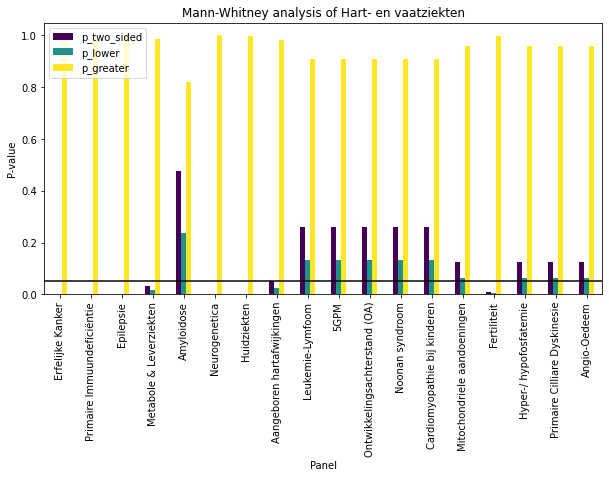

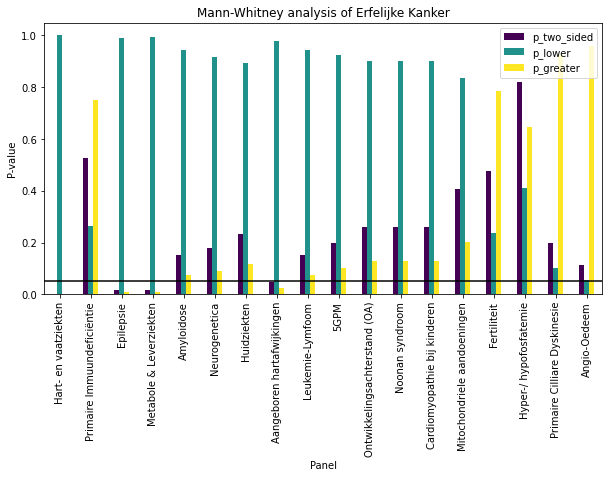

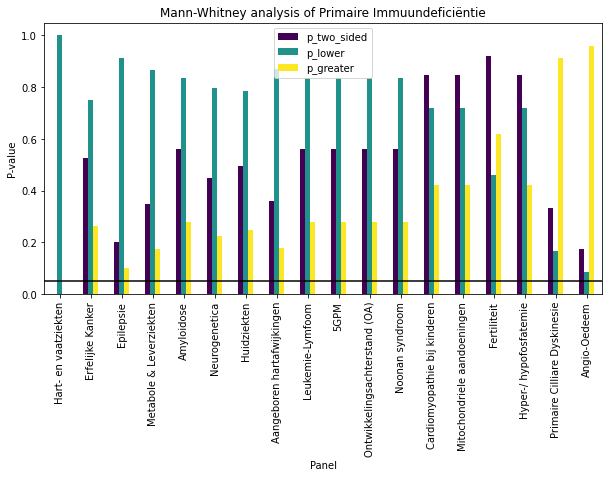

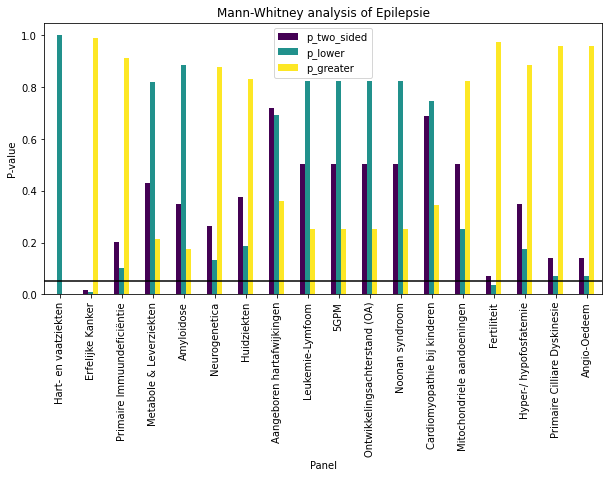

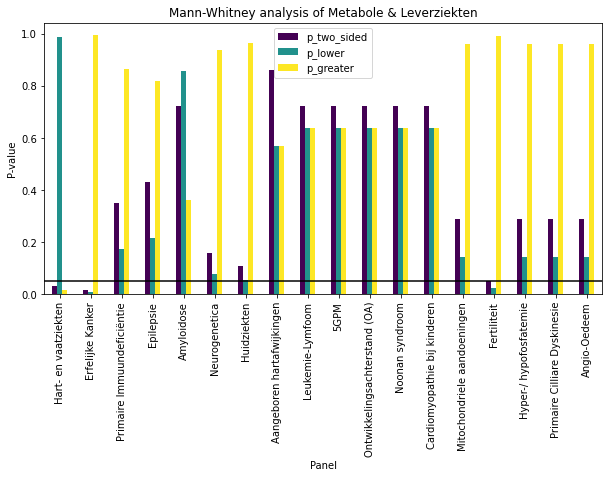

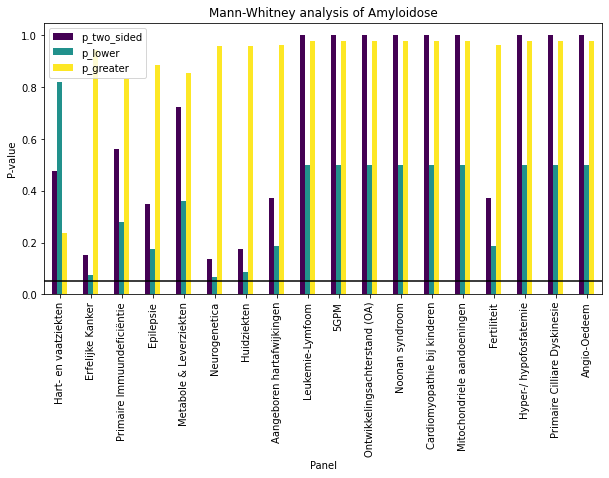

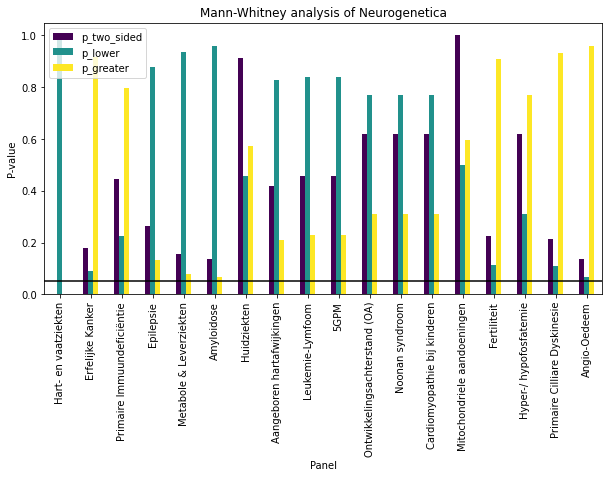

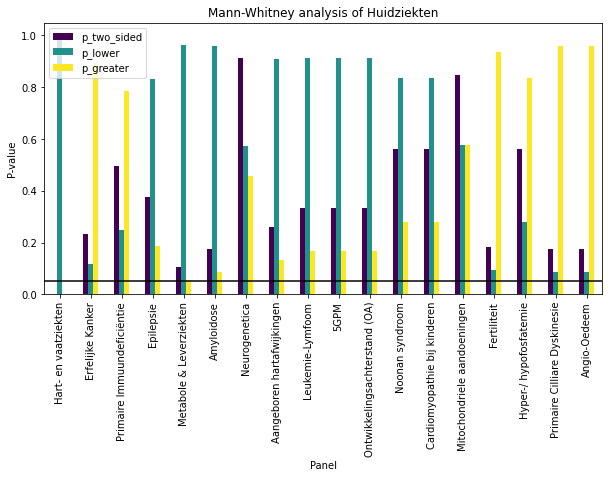

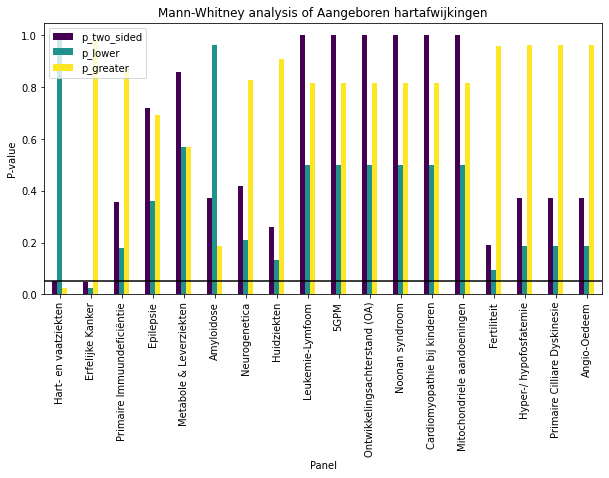

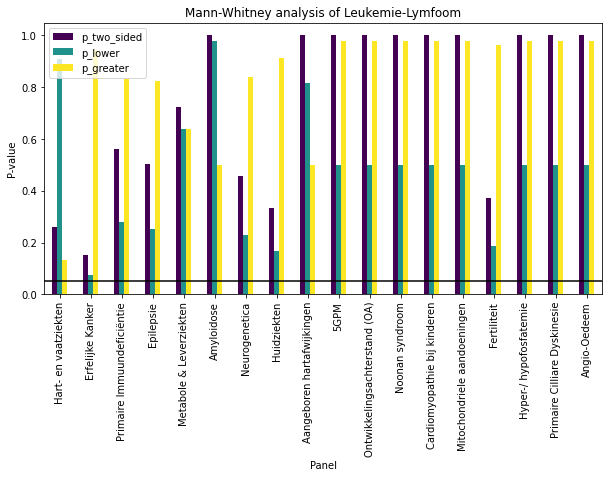

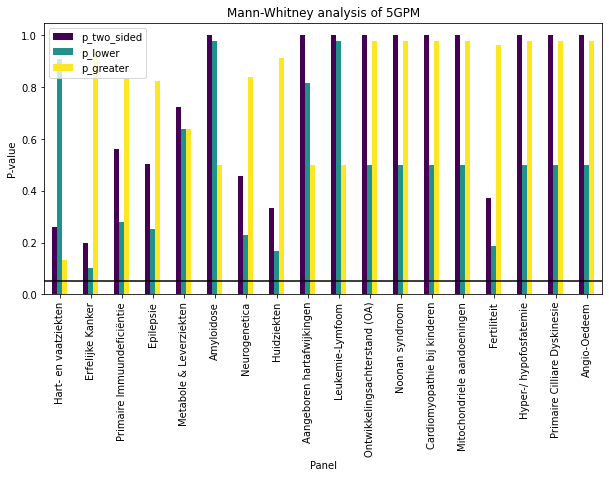

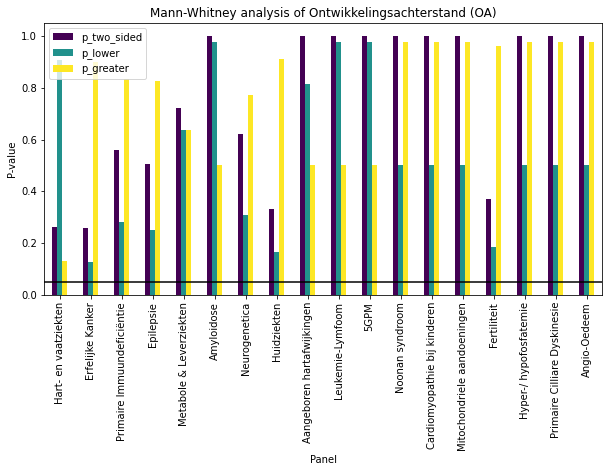

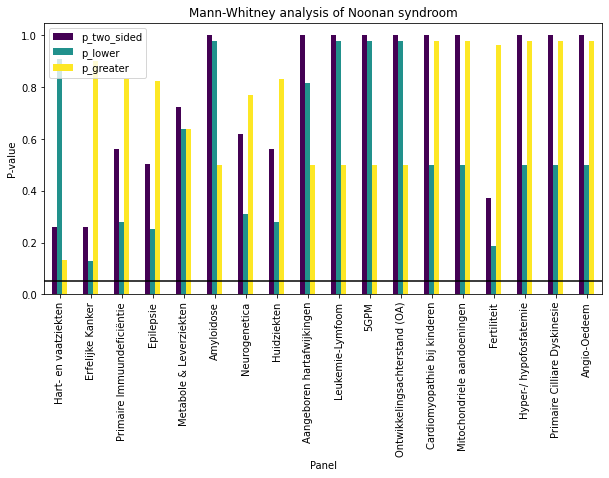

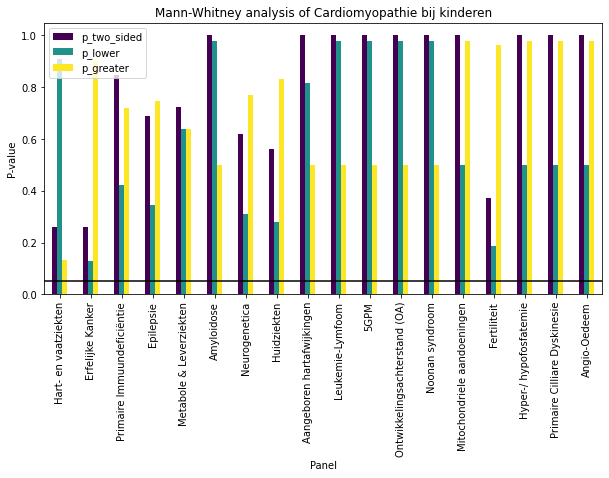

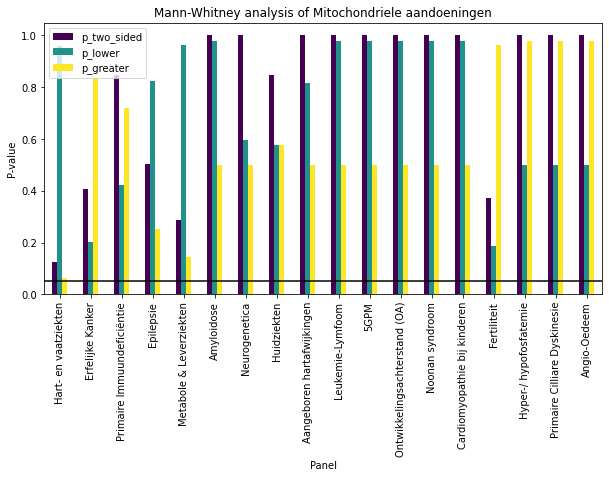

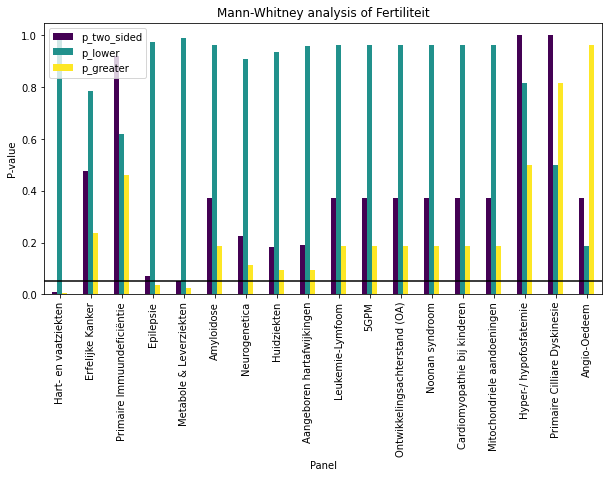

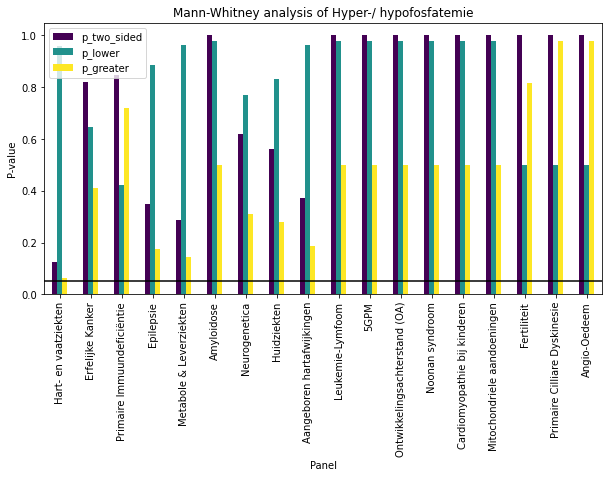

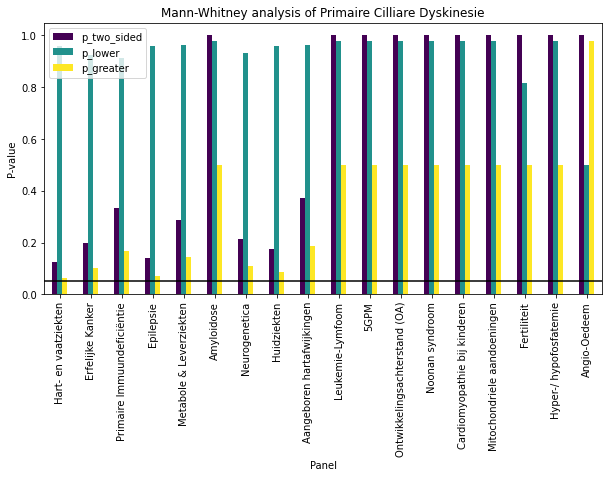

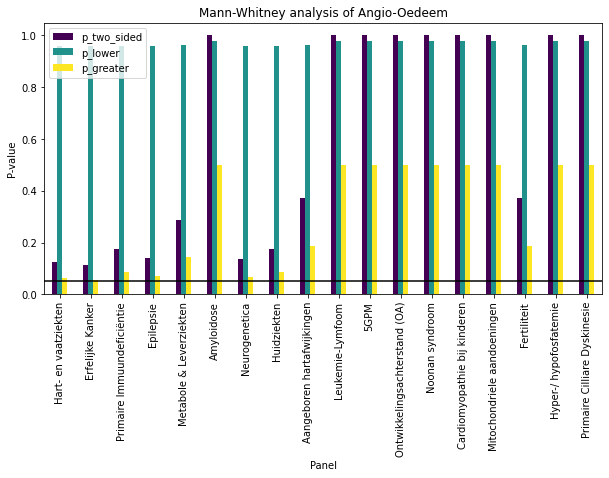

In [76]:
for category in wilcoxon_analysis['category'].unique():
    subset = wilcoxon_analysis[wilcoxon_analysis['category'] == category]
    ax = subset.plot.bar(x='compared_to',y=['p_two_sided', 'p_lower', 'p_greater'],
                         colormap='viridis',
                         figsize=(10,5),
                         title=f'Mann-Whitney analysis of {category}'
                        )
    ax.hlines(y=0.05,xmin=-10,xmax=100)
    ax.set_ylabel('P-value')
    ax.set_xlabel('Panel')

Now what do the plots above mean?

    - P_two_sided tests the null hypothesis that the distribution of title is different from the alternative. So when P is low, reject H0 (meaning there is a statisticial difference).
    - P_lower tests the alternative hypothesis that the median difference is negative. When P is low, reject H0, meaning that the median difference is negative. (If this value is low, it is statistically proven that x is lower than y)
    - P_higher tests the alternative hypothesis that the median difference is positive. When P is low, reject h0, meaning that the median difference is positive. (If this value is low, it is statistically proven that x is higher than y)

# From the Wilcoxon / Mannwhitney analysis
##### Hart- en vaatziekten
Every p_greater has a high P-value, indicating the category is not performing better than any other panel. Interestingly, Amyloidose, Leukemie-Lymfoom, 5GPM, OWA, Noonan syndroom, Cardiomyopathie bij kinderen, mitochondriele aandoeningen, hyper/hypofosfatemie, primaire cilliare dyskinesie en angio-oedeem also accepts H0 for two-sided and less, so it performs simular to them.
##### Erfelijke Kanker
Now quite the opposite of Hart- en vaatziekten, where p_lower accepts H0 except for maybe Angio-oedeem, meaning that everything is performing either worse or on par. Only Hart- en vaatziekten, epilepsie, metabole & leverziekten, aangeboren hartafwijkingen have some statistical proof of being better / worse than erfelijke kanker.
##### Primaire Immuundeficientie
Primaire immuundefientie is pretty much the average panel, only Hart- en vaatziekten performs statistically performs worse. Everything else is null hypothesis.
###### Angio-oedeem
Should be performing the best, a lot of high less p values is seen. But the null hypothesis for two-sided and greater can't be rejected in a single instance, so it might be performing better at sight, but it performs just average (which is good, this means CAPICE has a high average in the UMCG genepanels).


In [102]:
allvs1 = pd.DataFrame(columns=['two-sided', 'less', 'greater'])
for category in umcg_genepanel_analysis['category'].unique():
    if category == '5GPM':
        continue
    x = np.array(umcg_genepanel_analysis[umcg_genepanel_analysis['category'] == category]['avg_auc'])

    y = np.array(umcg_genepanel_analysis.where(
        ~(umcg_genepanel_analysis['category'] == category) & 
        ~(umcg_genepanel_analysis['category'] == '5GPM')
    ).dropna()['avg_auc'])
    output = {'category':'all',
              'compared_to':category,
              'two-sided':None,
              'less':None,
              'greater':None}
    for alternative in wilcoxon_alternatives:
        _, p = stats.mannwhitneyu(x, y, alternative=alternative)
        output[alternative] = p
    allvs1 = allvs1.append(
        pd.DataFrame(output, index=[0]), ignore_index=True
    )
allvs1        

,two-sided,less,greater,category,compared_to
0,8.387137e-08,4.193569e-08,1.000000,all,Hart- en vaatziekten
1,2.335297e-03,9.988650e-01,0.001168,all,Erfelijke Kanker
2,1.443765e-01,9.295787e-01,0.072188,all,Primaire Immuundeficiëntie
3,5.991497e-01,2.995749e-01,0.704180,all,Epilepsie
4,2.853821e-01,1.426910e-01,0.861318,all,Metabole & Leverziekten
5,2.889197e-01,1.444598e-01,0.863427,all,Amyloidose
6,4.634699e-01,7.714464e-01,0.231735,all,Neurogenetica
7,5.207033e-01,7.438423e-01,0.260352,all,Huidziekten
8,4.704156e-01,2.352078e-01,0.771085,all,Aangeboren hartafwijkingen
9,5.018088e-01,2.509044e-01,0.760216,all,Leukemie-Lymfoom


Text(0.5, 0, 'Panel')

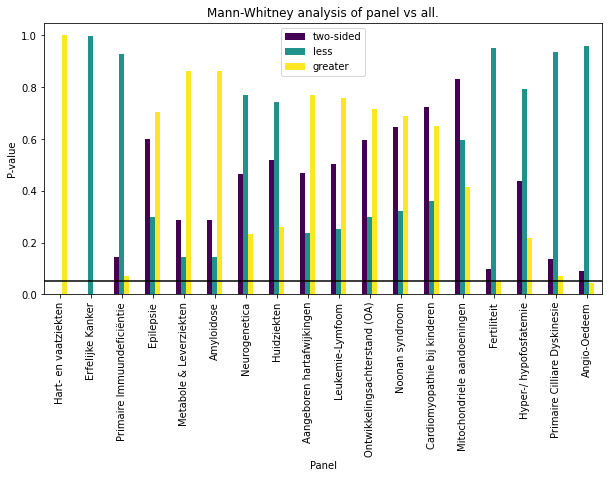

In [106]:
ax = allvs1.plot(y=['two-sided','less','greater'], x='compared_to', kind='bar', colormap='viridis', figsize=(10,5),
                title='Mann-Whitney analysis of panel vs all.')
ax.hlines(y=0.05,xmin=-10,xmax=100)
ax.set_ylabel('P-value')
ax.set_xlabel('Panel')

In [79]:
umcg_genepanel_analysis.where(~(umcg_genepanel_analysis['category'] == 'Hart- en vaatziekten') & 
                             ~(umcg_genepanel_analysis['category'] == '5GPM')).dropna()

,category,panel,min_auc,max_auc,avg_auc,std,med_auc,used%,used_n,genes_no_data,color,placeholder_x
78,Erfelijke Kanker,Endocrinologie-NET,0.500000,0.959184,0.833816,0.155455,0.906723,75,6/8,"[CDKN2B, CDKN2C]",#F06F1F,8.0
37,Primaire Immuundeficiëntie,Autoinflammatoir,0.500000,1.000000,0.862144,0.125045,0.883853,59,20/34,"[IL10, IL10RA, IL10RB, LACC1, OTULIN, POMP, PS...",#450A69,10.0
58,Epilepsie,Necrotiserende encefalopathie,0.862562,0.862562,0.862562,0.000000,0.862562,100,1/1,[],#70196E,11.0
48,Epilepsie,Focale epilepsie,0.500000,0.994318,0.875392,0.137229,0.940271,93,14/15,[NPRL2],#70196E,14.0
36,Primaire Immuundeficiëntie,CMC (Chronische mucocutane candidiasis),0.500000,1.000000,0.876051,0.190429,0.981250,71,5/7,"[IL17F, IL17RA]",#450A69,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...
91,Erfelijke Kanker,Longkanker,0.963235,0.963235,0.963235,0.000000,0.963235,100,1/1,[],#F06F1F,94.0
68,Fertiliteit,Congenitale Bilaterale Agenesie Vas Deferens (...,0.963502,0.963502,0.963502,0.000000,0.963502,50,1/2,[GPR64],#D54940,95.0
3,Neurogenetica,Neurodegeneratie met ijzerafzetting in de hers...,0.909926,1.000000,0.964537,0.031676,0.962963,100,9/9,[],#07051D,96.0
34,Primaire Immuundeficiëntie,B cel pathologie,0.914634,1.000000,0.966119,0.035738,0.976754,35,6/17,"[BLNK, CD40, CD79A, CD79B, CD81, ICOS, SH3KBP1...",#450A69,97.0


In [80]:
havd = output_genepanels['Hart- en vaatziekten']

In [81]:
lohavdg = [] # List Of Heart And Vascular Disease Genes
for key in havd.keys():
    if key.lower().startswith('dyslipid'):
        lohavdg = lohavdg + havd[key]
lohavdg = list(dict.fromkeys(lohavdg))

In [82]:
n_dislipid = pd.DataFrame(columns=['total', 'benign', 'malign'])
counting_dict = {
    'total':0,
    'benign':0,
    'malignant':0
}
for gene in lohavdg:
    subset = data[data['gene'] == gene]
    if subset.shape[0] > 0:
        counting_dict['total'] += subset['n_tot'].values[0]
        counting_dict['benign'] += subset['n_benign'].values[0]
        counting_dict['malignant'] += subset['n_malign'].values[0]
print(f"In dyslipidimie related genes, a total of {counting_dict['total']} variants are present, "
      f"of which {counting_dict['benign']} are benign and {counting_dict['malignant']} are malignant.")

In dyslipidimie related genes, a total of 8962 variants are present, of which 6950 are benign and 2012 are malignant.


In [83]:
data

,gene,default_auc,default_f1,default_recall,default_fpr,default_spec,optimal_c,optimal_auc,optimal_f1,optimal_recall,optimal_fpr,optimal_spec,n_tot,n_benign,n_malign
0,RDH12,0.839161,0.833333,0.909091,0.090909,0.909091,0.020,0.839161,0.833333,0.909091,0.090909,0.909091,24,13,11
1,EIF2AK4,0.981481,0.909091,1.000000,0.000000,1.000000,0.020,0.981481,0.909091,1.000000,0.000000,1.000000,32,27,5
2,EIF2AK3,0.966667,0.842105,1.000000,0.000000,1.000000,0.020,0.966667,0.842105,1.000000,0.000000,1.000000,53,45,8
3,PRKAG2,0.981203,0.761905,1.000000,0.000000,1.000000,0.020,0.981203,0.761905,1.000000,0.000000,1.000000,282,266,16
4,JAG1,0.925388,0.928994,0.987421,0.012579,0.987421,0.025,0.937810,0.940120,0.987421,0.012579,0.987421,320,161,159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2802,FLG2,1.000000,1.000000,1.000000,0.000000,1.000000,0.020,1.000000,1.000000,1.000000,0.000000,1.000000,4,3,1
2803,ACOX2,1.000000,1.000000,1.000000,0.000000,1.000000,0.020,1.000000,1.000000,1.000000,0.000000,1.000000,2,1,1
2804,SLITRK4,1.000000,1.000000,1.000000,0.000000,1.000000,0.020,1.000000,1.000000,1.000000,0.000000,1.000000,3,2,1
2805,POGLUT1,1.000000,1.000000,1.000000,0.000000,1.000000,0.020,1.000000,1.000000,1.000000,0.000000,1.000000,2,1,1


# Preparing ClinVar and VKGL databases
What genome build does VKGL have?
    - 37


In [84]:
def get_clinvar_header(clinvar_loc):
    header = None
    with gzip.open(clinvar_loc) as clinvar_file:
        while True:
            line = clinvar_file.readline().decode('utf-8')
            if line.startswith('#CHROM'):
                header = line.strip().split('\t')
                break
    return header
clinvar_loc = '/run/media/rjsietsma/evo2tb/linux/Datafiles/clinvar.vcf.gz'
header = get_clinvar_header(clinvar_loc)
clinvar = pd.read_csv(clinvar_loc, comment='#', names=header, sep='\t', compression='gzip')
clinvar = clinvar[~clinvar['INFO'].str.lower().str.contains('clnsig=uncertain')]
clinvar = clinvar.reset_index().drop('index', axis=1)
clinvar

/home/rjsietsma/PycharmProjects/dsls_master_thesis/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO
0,1,865628,789256,G,A,.,.,ALLELEID=707587;CLNDISDB=MedGen:CN517202;CLNDN...
1,1,874778,769497,GCCTCCCCAGCCACGGTGAGGACCCACCCTGGCATGATCCCCCTCATCA,G,.,.,ALLELEID=777163;CLNDISDB=MedGen:CN517202;CLNDN...
2,1,879481,780745,G,C,.,.,ALLELEID=707599;CLNDISDB=MedGen:CN517202;CLNDN...
3,1,880944,730521,G,A,.,.,ALLELEID=732665;CLNDISDB=MedGen:CN517202;CLNDN...
4,1,887409,735490,G,C,.,.,ALLELEID=746686;CLNDISDB=MedGen:CN517202;CLNDN...
...,...,...,...,...,...,...,...,...
430799,MT,15990,9570,C,T,.,.,ALLELEID=24609;CLNDISDB=Human_Phenotype_Ontolo...
430800,MT,15992,690268,A,T,.,.,"ALLELEID=677660;CLNDISDB=MONDO:MONDO:0010789,M..."
430801,MT,16002,690271,T,C,.,.,"ALLELEID=677663;CLNDISDB=MONDO:MONDO:0010789,M..."
430802,MT,16011,690273,A,G,.,.,"ALLELEID=677665;CLNDISDB=MONDO:MONDO:0010789,M..."


In [85]:
clinvar.loc[0,'INFO'].split(';')

['ALLELEID=707587',
 'CLNDISDB=MedGen:CN517202',
 'CLNDN=not_provided',
 'CLNHGVS=NC_000001.10:g.865628G>A',
 'CLNREVSTAT=criteria_provided,_single_submitter',
 'CLNSIG=Likely_benign',
 'CLNVC=single_nucleotide_variant',
 'CLNVCSO=SO:0001483',
 'GENEINFO=SAMD11:148398',
 'MC=SO:0001583|missense_variant',
 'ORIGIN=1']

In [86]:
clinvar.loc[0,:].str.contains('benign')['INFO']

True

In [87]:
def clinvar_extract_clnsig(x):
    return_value = np.NaN
    info_list = x.split(';')
    for y in info_list:
        if y.startswith('CLNSIG'):
            label = y.split('=')[1].lower()
            if (label.find('benign') != -1):
                return_value = 'LB'
            elif (label.find('pathogenic') != -1):
                return_value = 'LP'
    return return_value

In [88]:
clinvar['label'] = clinvar['INFO'].apply(lambda x: clinvar_extract_clnsig(x))
clinvar.dropna(axis=0, subset=['label'], inplace=True)
clinvar = clinvar.reset_index().drop('index', axis=1)
clinvar

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,label
0,1,865628,789256,G,A,.,.,ALLELEID=707587;CLNDISDB=MedGen:CN517202;CLNDN...,LB
1,1,874778,769497,GCCTCCCCAGCCACGGTGAGGACCCACCCTGGCATGATCCCCCTCATCA,G,.,.,ALLELEID=777163;CLNDISDB=MedGen:CN517202;CLNDN...,LB
2,1,879481,780745,G,C,.,.,ALLELEID=707599;CLNDISDB=MedGen:CN517202;CLNDN...,LB
3,1,880944,730521,G,A,.,.,ALLELEID=732665;CLNDISDB=MedGen:CN517202;CLNDN...,LB
4,1,887409,735490,G,C,.,.,ALLELEID=746686;CLNDISDB=MedGen:CN517202;CLNDN...,LB
...,...,...,...,...,...,...,...,...,...
414960,MT,15990,9570,C,T,.,.,ALLELEID=24609;CLNDISDB=Human_Phenotype_Ontolo...,LP
414961,MT,15992,690268,A,T,.,.,"ALLELEID=677660;CLNDISDB=MONDO:MONDO:0010789,M...",LB
414962,MT,16002,690271,T,C,.,.,"ALLELEID=677663;CLNDISDB=MONDO:MONDO:0010789,M...",LP
414963,MT,16011,690273,A,G,.,.,"ALLELEID=677665;CLNDISDB=MONDO:MONDO:0010789,M...",LB


In [90]:
vkgl = pd.read_csv('/run/media/rjsietsma/evo2tb/linux/Datafiles/VKGL_public_consensus_jun2020.csv.gz', compression='gzip')
vkgl = vkgl[vkgl['classification'] != 'VUS']

In [91]:
vkgl.drop_duplicates(subset=['chromosome','start','ref','alt'], inplace=True)
vkgl = vkgl.reset_index().drop('index',axis=1)[['chromosome','start','ref','alt','classification']]
vkgl_cols = ['#CHROM','POS','REF','ALT', 'label']
vkgl.columns = vkgl_cols
vkgl['INFO'] = '.'

In [92]:
clinvar_vkgl = clinvar.append(vkgl, ignore_index=True).drop(['ID','QUAL','FILTER'], axis=1)

In [93]:
def build_nondupe_clinvarvkgl(x):
    dupe_check = vkgl_cols[:-1]
    label_check = vkgl_cols
    if (vkgl[vkgl_cols] == x[vkgl_cols]).all(axis=1).sum() > 0:
        print(x)